The code presented in this notebook partially uses code used in the 4th practical.

In [7]:
# Make sure to have installed torch-scatter, torch-sparse, torch-cluster,
#   an example for installing them is below, you may need to change versions for pytorch and cuda

# Other packages: pandas, seaborn, matplotlib

%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu117.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu117.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.1+cu117.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [124]:
# Imports
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv, GATConv, GATv2Conv

Loading the PubMed dataset

In [278]:
dataset = datasets.Planetoid(
    root="./",
    name='PubMed',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )

Processing...
Done!


Different networks types

- `GCN`: A model using a variable number of GCNConv layers with dropout
- `SimpleGAT`: A model using a variable amount of GATConv layers with dropout
- `InterleaveGATGCN`: A model alternating layers of the type GAT and GCN

Note that `SimpleGAT` and `InterleaveGATGCN` have the option to use GATv2Conv layers

In [279]:
class GCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(GCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.dropout_ratio = dropout_ratio

    self.layers = nn.ModuleList([])
    self.dropouts = nn.ModuleList([])

    dimensions = [hid_dim] * n_layers + [n_classes]
    last_dim = input_dim
    for act_dim in dimensions:
      self.layers.append(GCNConv(last_dim, act_dim))
      self.dropouts.append(nn.Dropout(self.dropout_ratio))
      last_dim = act_dim  


  def forward(self, X, A) -> torch.Tensor:
    for i in range(len(self.layers)):
      X = self.layers[i](X, A)
      if i + 1 < len(self.layers):
        X = F.relu(X)
        X = self.dropouts[i](X)

    X = F.log_softmax(X, dim=1)

    return X

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    cnt_layers = len(self.layers)
    for i in range(cnt_layers):
      X = self.layers[i](X, A)
      if i + 1 < cnt_layers:
        X = F.relu(X)
        X = self.dropouts[i](X)

    return X
  
  def param_init(self):
    
    pass

In [280]:
class SimpleGAT(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3,
      use_v2: bool = False):
    super(SimpleGAT, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.dropout_ratio = dropout_ratio

    self.layers = nn.ModuleList([])

    dimensions = [hid_dim] * n_layers + [n_classes]
    last_dim = input_dim
    for act_dim in dimensions:
      if use_v2:
        self.layers.append(GATv2Conv(last_dim, act_dim, dropout=self.dropout_ratio, add_self_loops=False))
      else:
        self.layers.append(GATConv(last_dim, act_dim, dropout=self.dropout_ratio, add_self_loops=False))
      last_dim = act_dim  


  def forward(self, X, A) -> torch.Tensor:
    self.saved_alpha = []

    for i in range(len(self.layers)):
      X, alpha = self.layers[i](X, A, return_attention_weights=True)
      self.saved_alpha.append(alpha)
      if i + 1 < len(self.layers):
        X = F.relu(X)

    X = F.log_softmax(X, dim=1)

    return X
  

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    cnt_layers = len(self.layers)
    for i in range(cnt_layers):
      X = self.layers[i](X, A)
      if i + 1 < cnt_layers:
        X = F.relu(X)

    return X

  
  def param_init(self):
    
    pass

In [281]:
class InterleaveGATGCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3,
      use_v2: bool = False,
      gat_first: bool = False):
    super(InterleaveGATGCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.dropout_ratio = dropout_ratio

    self.layers = nn.ModuleList([])
    self.dropouts = nn.ModuleList([])
    
    dimensions = [hid_dim] * n_layers + [n_classes]
    last_dim = input_dim
    layer_index = 1 if gat_first else 0
    for act_dim in dimensions:
      gat_layer = GATv2Conv(last_dim, act_dim) if use_v2 else GATConv(last_dim, act_dim)
      gcn_layer = GATConv(last_dim, act_dim)

      if layer_index % 2 == 1:
        self.layers.append(gat_layer)
      else:
        self.layers.append(gcn_layer)

      self.dropouts.append(nn.Dropout(self.dropout_ratio))

      last_dim = act_dim  
      layer_index += 1


  def forward(self, X, A) -> torch.Tensor:
    for i in range(len(self.layers)):
      X = self.layers[i](X, A)
      if i + 1 < len(self.layers):
        X = F.relu(X)
        X = self.dropouts[i](X)

    X = F.log_softmax(X, dim=1)

    return X

    

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    cnt_layers = len(self.layers)
    for i in range(cnt_layers):
      X = self.layers[i](X, A)
      if i + 1 < cnt_layers:
        X = F.relu(X)
        X = self.dropouts[i](X)

    return X

  
  def param_init(self):
    
    pass

Train, evaluate and plot functions

In [282]:
def evaluate(
    model,
    data,
    mask,
    is_eval
):
    model.eval()

    labels = model(data.x, data.edge_index)
    pred = torch.argmax(labels, dim=1)[mask]
    
    accuracy = torch.mean((pred == data.y[mask]).float()).item()

    return accuracy
    

In [313]:
from matplotlib import pyplot as plt

def do_plot(train_acc, test_acc):
    plt.plot(train_acc, label="train")
    plt.plot(test_acc, label="validation")
    plt.legend()
    plt.show()

In [314]:
def train(
    params: typing.Dict
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """
  # set device
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # load dataset
  data = dataset.data
  data = data.to(device)

  # Update parameters
  params["n_classes"] = dataset.num_classes # number of target classes
  params["input_dim"] = dataset.num_features # size of input features

  # Set a model
  if params['model_name'] == 'GCN':
      model = GCN(
        params["input_dim"], 
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
        ).to(device)
  elif params['model_name'] == 'SimpleGAT':
      model = SimpleGAT(
        params["input_dim"], 
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        use_v2= params["use_v2"]
        ).to(device)
  elif params['model_name'] == 'InterleaveGATGCN':
      model = InterleaveGATGCN(
        params["input_dim"], 
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        use_v2= params["use_v2"],
        gat_first= params["gat_first"]
        ).to(device)
  else:
      raise NotImplementedError

  model.param_init()

  torch.autograd.set_detect_anomaly(True) 

  accuracies = []

  loss_fn = nn.CrossEntropyLoss()

  last_acc, cnt_decreasing = None, 0
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=params["lr"],
                                weight_decay=params["weight_decay"])
  
  train_acc = []
  val_acc = []

  for e in range(params["epochs"]):
    # do train
    model.train()
    optimizer.zero_grad()

    labels = model(data.x, data.edge_index)
    pred = torch.argmax(labels, dim=1)[data.train_mask]
    loss = loss_fn(labels[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_accuracy = torch.mean((pred == data.y[data.train_mask]).float()).item()
    train_acc.append(train_accuracy)

    # do test
    val_accuracy = evaluate(model, data, data.val_mask, True)
    val_acc.append(val_accuracy)

    print(f"Validation accuracy: {val_accuracy*100:.2f}")
    if last_acc is not None:
      if last_acc > val_accuracy:
        cnt_decreasing += 1
    
    last_acc = val_accuracy
    if cnt_decreasing >= params["max_patience"]:
      print("Early stopping...")
      break

  test_accuracy = evaluate(model, data, data.test_mask, True)
  print(f"Final test accuracy: {test_accuracy*100:.2f}")
  do_plot(train_acc, val_acc)

  return model, test_accuracy

Setting hyper-parameters

In [315]:
import copy

training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 200,  # number of total training epochs
    "max_patience": 6, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GCN"
}

gat_params = copy.deepcopy(training_params)
gat_params['model_name'] = 'SimpleGAT'
gat_params['use_v2'] = False

gatv2_params = copy.deepcopy(gat_params)
gatv2_params['model_name'] =  'SimpleGAT'
gatv2_params['use_v2'] = True

interleave_params = copy.deepcopy(gat_params)
interleave_params['model_name'] = 'InterleaveGATGCN'
interleave_params['gat_first'] = True

interleavev2_params = copy.deepcopy(gatv2_params)
interleavev2_params['model_name'] = 'InterleaveGATGCN'
interleavev2_params['gat_first'] = True


In [297]:
torch.manual_seed(234) # set seed

In [316]:
from typing import Dict

def model_n_layer(params: Dict, layers: int):
    params['n_layers'] = layers
    return train(params)

Validation accuracy: 47.00
Validation accuracy: 51.60
Validation accuracy: 57.20
Validation accuracy: 62.20
Validation accuracy: 67.20
Validation accuracy: 70.00
Validation accuracy: 70.40
Validation accuracy: 70.40
Validation accuracy: 71.20
Validation accuracy: 71.40
Validation accuracy: 72.60
Validation accuracy: 72.60
Validation accuracy: 72.80
Validation accuracy: 72.80
Validation accuracy: 72.80
Validation accuracy: 72.60
Validation accuracy: 72.60
Validation accuracy: 72.80
Validation accuracy: 73.20
Validation accuracy: 73.40
Validation accuracy: 73.20
Validation accuracy: 72.80
Validation accuracy: 72.80
Validation accuracy: 72.80
Validation accuracy: 73.00
Validation accuracy: 73.00
Validation accuracy: 72.80
Validation accuracy: 72.60
Validation accuracy: 72.80
Validation accuracy: 73.00
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 73.60
Validation accuracy: 73.60
Validation accuracy: 73.60
Validation accuracy: 73.60
Validation accuracy: 73.60
V

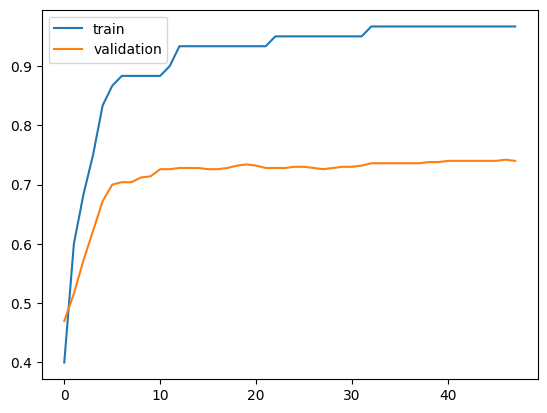

Validation accuracy: 47.80
Validation accuracy: 59.80
Validation accuracy: 65.60
Validation accuracy: 70.80
Validation accuracy: 72.20
Validation accuracy: 73.00
Validation accuracy: 74.20
Validation accuracy: 73.60
Validation accuracy: 74.00
Validation accuracy: 74.00
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 74.60
Validation accuracy: 75.00
Validation accuracy: 75.20
Validation accuracy: 75.20
Validation accuracy: 75.20
Validation accuracy: 75.40
Validation accuracy: 75.20
Validation accuracy: 75.20
Validation accuracy: 75.20
Validation accuracy: 75.00
Validation accuracy: 75.20
Validation accuracy: 75.40
Validation accuracy: 75.40
Validation accuracy: 75.40
Validation accuracy: 75.60
Validation accuracy: 75.60
Validation accuracy: 75.60
Validation accuracy: 75.40
Validation accuracy: 76.00
Validation accuracy: 75.80
E

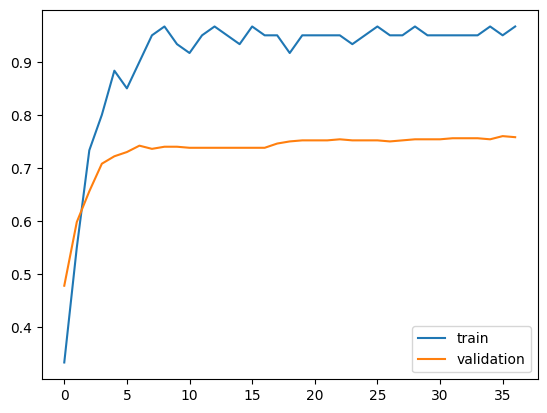

Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 25.40
Validation accuracy: 37.80
Validation accuracy: 53.00
Validation accuracy: 65.00
Validation accuracy: 68.60
Validation accuracy: 69.20
Validation accuracy: 70.00
Validation accuracy: 71.60
Validation accuracy: 71.80
Validation accuracy: 72.40
Validation accuracy: 74.20
Validation accuracy: 75.00
Validation accuracy: 75.40
Validation accuracy: 76.00
Validation accuracy: 76.20
Validation accuracy: 76.00
Validation accuracy: 76.60
Validation accuracy: 76.40
Validation accuracy: 75.80
Validation accuracy: 77.60
Validation accuracy: 76.80
Validation accuracy: 77.40
Validation accuracy: 76.80
Validation accuracy: 78.00
Validation accuracy: 78.00
Validation accuracy: 77.80
Early stopping...
Final test accuracy: 77.10


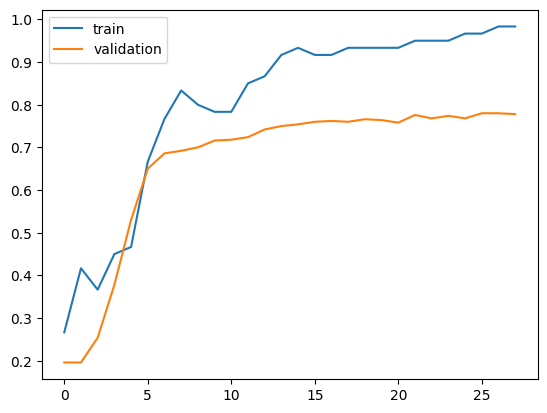

Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 26.20
Validation accuracy: 39.40
Validation accuracy: 50.60
Validation accuracy: 52.00
Validation accuracy: 54.40
Validation accuracy: 52.80
Validation accuracy: 53.20
Validation accuracy: 55.00
Validation accuracy: 50.60
Validation accuracy: 50.20
Validation accuracy: 53.60
Validation accuracy: 54.80
Validation accuracy: 49.20
Validation accuracy: 49.20
Validation accuracy: 50.40
Validation accuracy: 50.00
Validation accuracy: 48.40
Early stopping...
Final test accuracy: 49.30


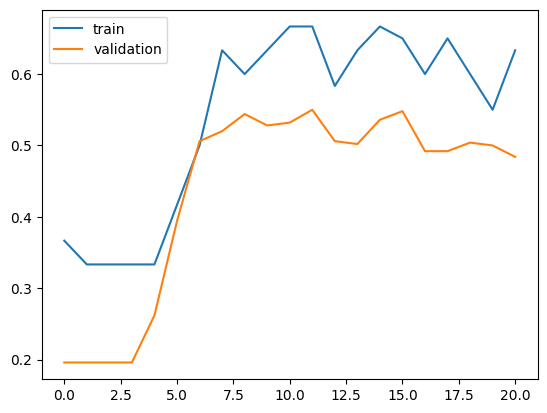

In [317]:
gcn_0, _ = model_n_layer(training_params, 0)
gcn_1, _ = model_n_layer(training_params, 1)
gcn_3, _ = model_n_layer(training_params, 3)
gcn_10, _ = model_n_layer(training_params, 10)

Validation accuracy: 43.20
Validation accuracy: 47.40
Validation accuracy: 51.00
Validation accuracy: 55.00
Validation accuracy: 59.20
Validation accuracy: 61.00
Validation accuracy: 62.80
Validation accuracy: 64.80
Validation accuracy: 66.00
Validation accuracy: 68.20
Validation accuracy: 68.60
Validation accuracy: 69.00
Validation accuracy: 68.80
Validation accuracy: 68.60
Validation accuracy: 69.20
Validation accuracy: 69.00
Validation accuracy: 68.00
Validation accuracy: 69.40
Validation accuracy: 69.60
Validation accuracy: 71.00
Validation accuracy: 71.00
Validation accuracy: 70.40
Validation accuracy: 70.60
Validation accuracy: 71.00
Validation accuracy: 71.20
Validation accuracy: 71.20
Validation accuracy: 70.80
Early stopping...
Final test accuracy: 66.90


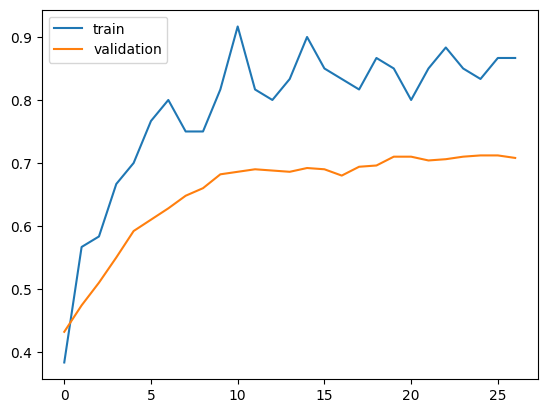

Validation accuracy: 61.60
Validation accuracy: 71.20
Validation accuracy: 70.20
Validation accuracy: 70.20
Validation accuracy: 70.00
Validation accuracy: 69.60
Validation accuracy: 69.20
Validation accuracy: 69.40
Validation accuracy: 70.00
Validation accuracy: 69.60
Validation accuracy: 70.00
Validation accuracy: 69.80
Early stopping...
Final test accuracy: 68.80


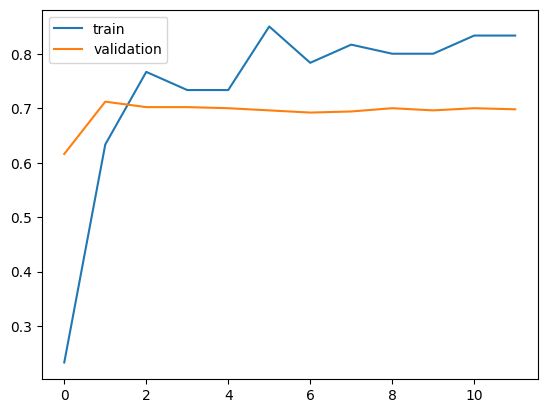

Validation accuracy: 19.60
Validation accuracy: 42.60
Validation accuracy: 44.00
Validation accuracy: 47.20
Validation accuracy: 61.80
Validation accuracy: 68.80
Validation accuracy: 69.40
Validation accuracy: 71.20
Validation accuracy: 71.80
Validation accuracy: 71.60
Validation accuracy: 73.00
Validation accuracy: 72.20
Validation accuracy: 72.60
Validation accuracy: 74.20
Validation accuracy: 75.40
Validation accuracy: 75.40
Validation accuracy: 75.40
Validation accuracy: 76.20
Validation accuracy: 76.00
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.40
Validation accuracy: 75.00
Validation accuracy: 74.00
Validation accuracy: 74.80
Validation accuracy: 75.40
Validation accuracy: 75.60
Validation accuracy: 76.00
Validation accuracy: 76.00
Validation accuracy: 75.40
Early stopping...
Final test accuracy: 75.00


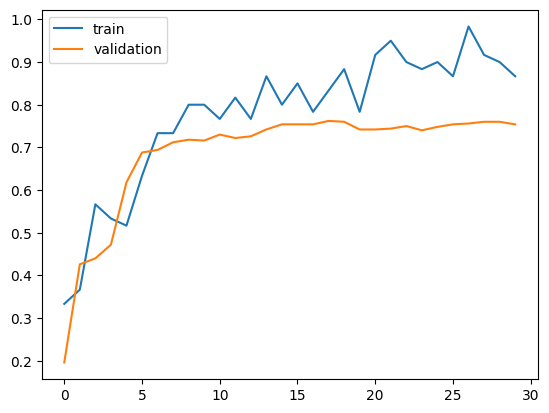

Validation accuracy: 38.80
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 50.80
Validation accuracy: 52.00
Validation accuracy: 50.60
Validation accuracy: 52.40
Validation accuracy: 51.20
Validation accuracy: 53.00
Validation accuracy: 52.20
Validation accuracy: 49.40
Validation accuracy: 53.80
Validation accuracy: 54.60
Validation accuracy: 55.40
Validation accuracy: 58.20
Validation accuracy: 54.60
Early stopping...
Final test accuracy: 53.40


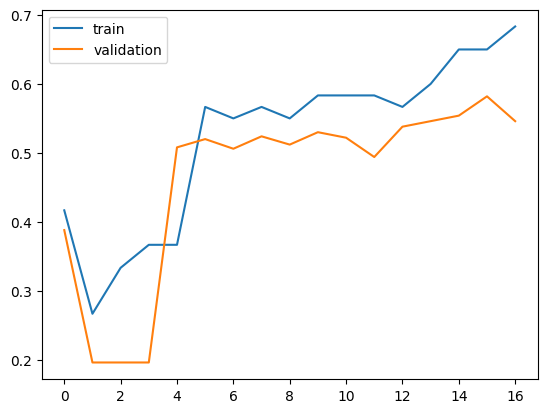

In [318]:
gat_0, _ = model_n_layer(gat_params, 0)
gat_1, _ = model_n_layer(gat_params, 1)
gat_3, _ = model_n_layer(gat_params, 3)
gat_10, _ = model_n_layer(gat_params, 10)

Validation accuracy: 18.60
Validation accuracy: 24.40
Validation accuracy: 34.00
Validation accuracy: 48.40
Validation accuracy: 54.20
Validation accuracy: 54.00
Validation accuracy: 56.80
Validation accuracy: 60.20
Validation accuracy: 63.40
Validation accuracy: 67.20
Validation accuracy: 68.20
Validation accuracy: 68.40
Validation accuracy: 69.00
Validation accuracy: 71.20
Validation accuracy: 69.80
Validation accuracy: 69.40
Validation accuracy: 69.40
Validation accuracy: 70.60
Validation accuracy: 70.60
Validation accuracy: 70.40
Validation accuracy: 70.40
Validation accuracy: 70.60
Validation accuracy: 70.20
Validation accuracy: 69.20
Early stopping...
Final test accuracy: 66.80


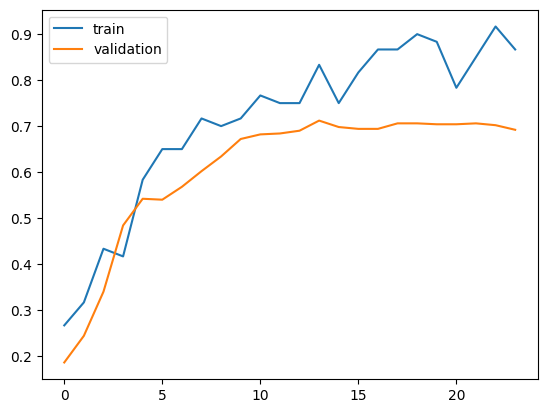

Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 46.80
Validation accuracy: 53.40
Validation accuracy: 54.80
Validation accuracy: 68.20
Validation accuracy: 71.80
Validation accuracy: 72.00
Validation accuracy: 71.80
Validation accuracy: 72.40
Validation accuracy: 71.60
Validation accuracy: 71.20
Validation accuracy: 71.40
Validation accuracy: 72.00
Validation accuracy: 72.00
Validation accuracy: 72.80
Validation accuracy: 73.20
Validation accuracy: 73.20
Validation accuracy: 73.20
Validation accuracy: 73.40
Validation accuracy: 72.80
Validation accuracy: 73.20
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 73.60
Validation accuracy: 73.20
Early stopping...
Final test accuracy: 72.30


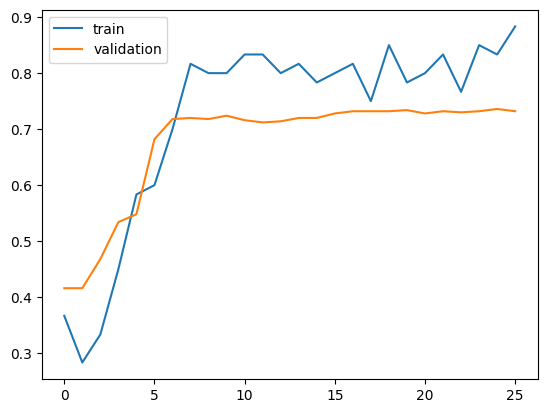

Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 44.80
Validation accuracy: 53.00
Validation accuracy: 60.40
Validation accuracy: 42.00
Validation accuracy: 51.00
Validation accuracy: 64.60
Validation accuracy: 70.00
Validation accuracy: 70.20
Validation accuracy: 71.20
Validation accuracy: 70.80
Validation accuracy: 72.40
Validation accuracy: 70.20
Validation accuracy: 70.80
Validation accuracy: 74.20
Validation accuracy: 75.60
Validation accuracy: 76.40
Validation accuracy: 74.20
Validation accuracy: 75.60
Validation accuracy: 76.00
Validation accuracy: 76.60
Validation accuracy: 73.60
Validation accuracy: 77.00
Validation accuracy: 75.40
Early stopping...
Final test accuracy: 73.30


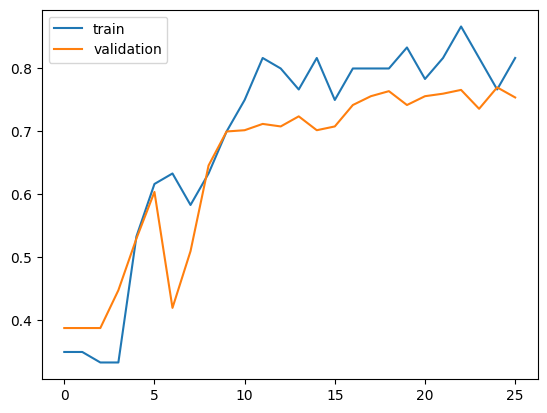

Validation accuracy: 38.80
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 53.20
Validation accuracy: 60.20
Validation accuracy: 50.80
Validation accuracy: 53.20
Validation accuracy: 53.00
Validation accuracy: 52.40
Validation accuracy: 52.80
Validation accuracy: 52.60
Validation accuracy: 37.00
Early stopping...
Final test accuracy: 35.40


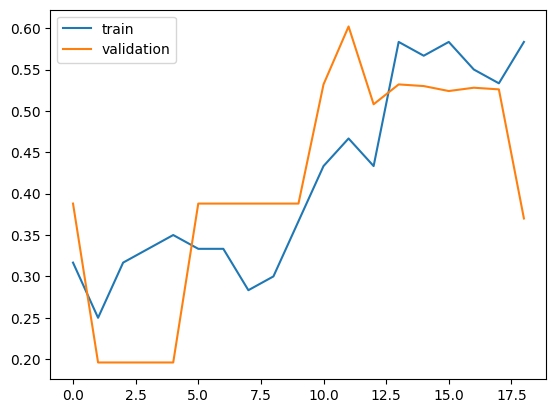

In [319]:
gatv2_0, _ = model_n_layer(gatv2_params, 0)
gatv2_1, _ = model_n_layer(gatv2_params, 1)
gatv2_3, _ = model_n_layer(gatv2_params, 3)
gatv2_10, _ = model_n_layer(gatv2_params, 10)

Validation accuracy: 43.20
Validation accuracy: 45.40
Validation accuracy: 51.40
Validation accuracy: 55.80
Validation accuracy: 62.60
Validation accuracy: 66.80
Validation accuracy: 67.80
Validation accuracy: 69.40
Validation accuracy: 70.80
Validation accuracy: 71.40
Validation accuracy: 71.40
Validation accuracy: 71.60
Validation accuracy: 72.20
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 73.40
Validation accuracy: 73.60
Validation accuracy: 74.00
Validation accuracy: 74.20
Validation accuracy: 74.60
Validation accuracy: 74.60
Validation accuracy: 74.60
Validation accuracy: 74.60
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.00
Validation accuracy: 74.00
Validation accuracy: 73.60
Validation accuracy: 73.60
Validation accuracy: 73.60
Validation accuracy: 73.60
Validation accuracy: 73.60
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.60
V

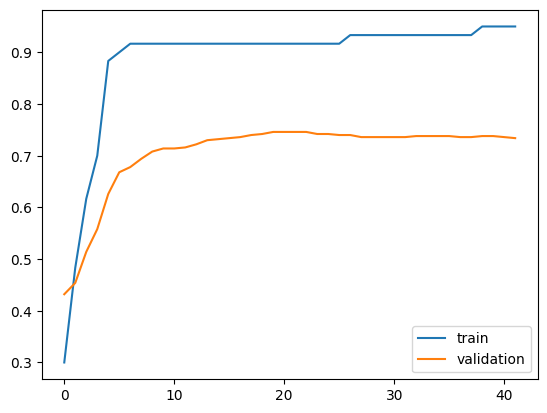

Validation accuracy: 54.20
Validation accuracy: 67.40
Validation accuracy: 72.60
Validation accuracy: 73.40
Validation accuracy: 74.80
Validation accuracy: 74.20
Validation accuracy: 73.80
Validation accuracy: 72.60
Validation accuracy: 72.40
Validation accuracy: 72.60
Validation accuracy: 72.60
Validation accuracy: 72.60
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 73.20
Validation accuracy: 73.60
Validation accuracy: 73.80
Validation accuracy: 74.00
Validation accuracy: 74.60
Validation accuracy: 74.80
Validation accuracy: 74.60
Validation accuracy: 74.60
Validation accuracy: 74.80
Validation accuracy: 75.40
Validation accuracy: 75.20
Early stopping...
Final test accuracy: 73.80


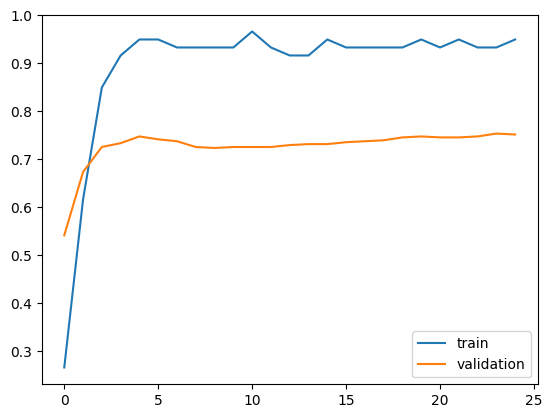

Validation accuracy: 45.80
Validation accuracy: 68.80
Validation accuracy: 68.60
Validation accuracy: 69.00
Validation accuracy: 69.40
Validation accuracy: 71.20
Validation accuracy: 71.00
Validation accuracy: 70.40
Validation accuracy: 70.80
Validation accuracy: 71.60
Validation accuracy: 72.80
Validation accuracy: 73.60
Validation accuracy: 74.40
Validation accuracy: 75.60
Validation accuracy: 76.40
Validation accuracy: 78.20
Validation accuracy: 79.20
Validation accuracy: 79.00
Validation accuracy: 77.20
Validation accuracy: 75.20
Early stopping...
Final test accuracy: 70.70


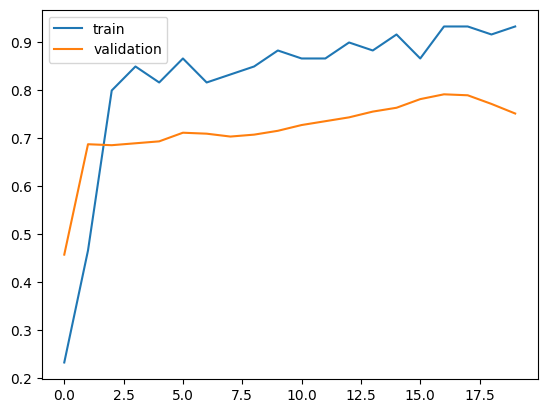

Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 51.80
Validation accuracy: 54.80
Validation accuracy: 59.60
Validation accuracy: 61.00
Validation accuracy: 61.40
Validation accuracy: 65.60
Validation accuracy: 50.40
Validation accuracy: 49.40
Validation accuracy: 59.80
Validation accuracy: 56.40
Validation accuracy: 66.00
Validation accuracy: 62.20
Validation accuracy: 62.00
Validation accuracy: 64.20
Validation accuracy: 65.60
Validation accuracy: 65.00
Early stopping...
Final test accuracy: 63.60


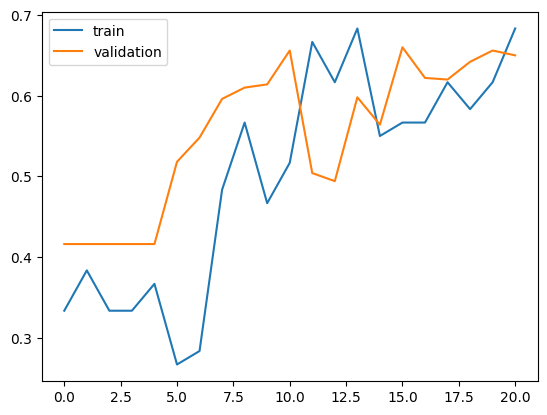

In [333]:
interleave_0, _ = model_n_layer(interleave_params, 0)
interleave_1, _ = model_n_layer(interleave_params, 1)
interleave_3, _ = model_n_layer(interleave_params, 3)
interleave_10, _ = model_n_layer(interleave_params, 10)

In [ ]:
interleavev2_0, _ = model_n_layer(interleavev2_params, 0)
interleavev2_1, _ = model_n_layer(interleavev2_params, 1)
interleavev2_3, _ = model_n_layer(interleavev2_params, 3)
interleavev2_10, _ = model_n_layer(interleavev2_params, 10)

training GCN layers: 0
Validation accuracy: 34.60
Validation accuracy: 40.60
Validation accuracy: 47.60
Validation accuracy: 54.60
Validation accuracy: 58.00
Validation accuracy: 61.20
Validation accuracy: 63.60
Validation accuracy: 65.40
Validation accuracy: 67.60
Validation accuracy: 67.60
Validation accuracy: 67.00
Validation accuracy: 67.80
Validation accuracy: 68.80
Validation accuracy: 69.40
Validation accuracy: 69.40
Validation accuracy: 70.60
Validation accuracy: 71.40
Validation accuracy: 71.40
Validation accuracy: 71.60
Validation accuracy: 71.40
Validation accuracy: 71.60
Validation accuracy: 71.80
Validation accuracy: 72.00
Validation accuracy: 72.20
Validation accuracy: 72.40
Validation accuracy: 72.60
Validation accuracy: 73.00
Validation accuracy: 72.80
Validation accuracy: 73.20
Validation accuracy: 73.00
Validation accuracy: 73.00
Validation accuracy: 73.00
Validation accuracy: 73.00
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 73.20
Valid

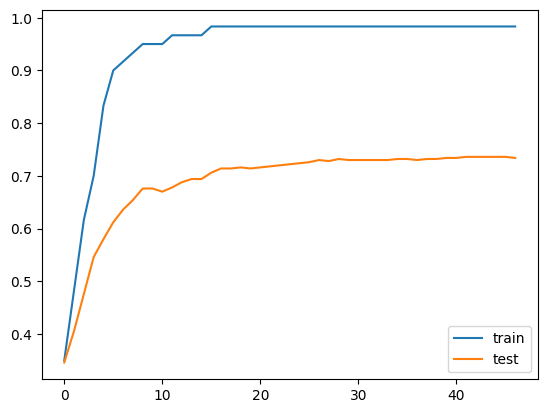

training GCN layers: 1
Validation accuracy: 60.80
Validation accuracy: 68.80
Validation accuracy: 72.20
Validation accuracy: 72.80
Validation accuracy: 72.80
Validation accuracy: 73.20
Validation accuracy: 73.40
Validation accuracy: 73.20
Validation accuracy: 73.20
Validation accuracy: 73.20
Validation accuracy: 73.40
Validation accuracy: 73.40
Validation accuracy: 73.40
Validation accuracy: 73.80
Validation accuracy: 74.00
Validation accuracy: 74.00
Validation accuracy: 74.60
Validation accuracy: 74.40
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.80
Validation accuracy: 75.40
Validation accuracy: 75.40
Validation accuracy: 75.80
Validation accuracy: 75.80
Validation accuracy: 76.00
Validation accuracy: 76.00
Validation accuracy: 76.00
Validation accuracy: 76.20
Validation accuracy: 75.80
Validation accuracy: 76.20
Validation accuracy: 76.60
Validation accuracy: 76.80
Validation accuracy: 77.00
Validation accuracy: 77.20
Valid

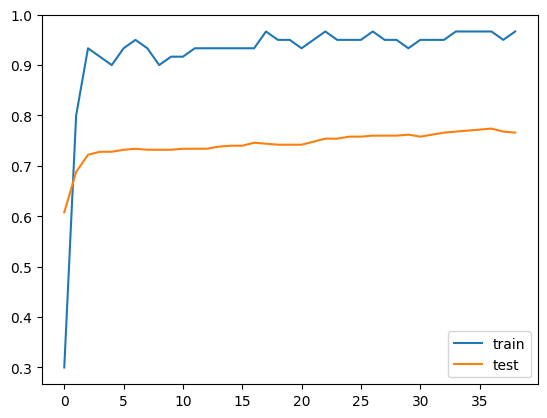

training GCN layers: 2
Validation accuracy: 37.00
Validation accuracy: 50.20
Validation accuracy: 63.60
Validation accuracy: 70.60
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 73.20
Validation accuracy: 73.80
Validation accuracy: 74.20
Validation accuracy: 73.20
Validation accuracy: 73.80
Validation accuracy: 74.80
Validation accuracy: 75.20
Validation accuracy: 75.40
Validation accuracy: 75.20
Validation accuracy: 75.20
Validation accuracy: 75.60
Validation accuracy: 75.60
Validation accuracy: 75.60
Validation accuracy: 75.40
Validation accuracy: 75.20
Validation accuracy: 75.40
Validation accuracy: 75.40
Validation accuracy: 75.40
Validation accuracy: 76.40
Validation accuracy: 76.60
Validation accuracy: 77.20
Validation accuracy: 77.20
Validation accuracy: 78.00
Validation accuracy: 77.80
Validation accuracy: 77.80
Validation accuracy: 77.40
Early stopping...
Final test accuracy: 75.50


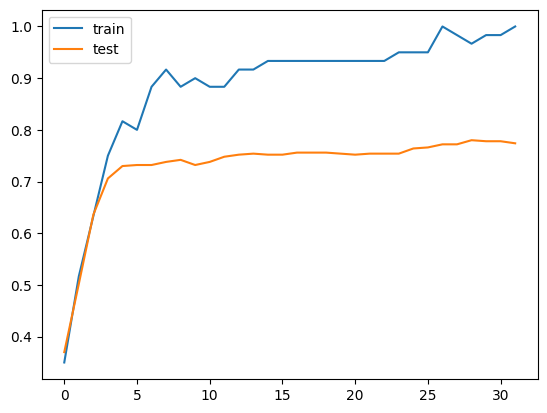

training GCN layers: 3
Validation accuracy: 50.80
Validation accuracy: 64.00
Validation accuracy: 73.40
Validation accuracy: 73.80
Validation accuracy: 74.20
Validation accuracy: 73.40
Validation accuracy: 72.60
Validation accuracy: 73.00
Validation accuracy: 73.80
Validation accuracy: 74.60
Validation accuracy: 74.40
Validation accuracy: 74.60
Validation accuracy: 75.00
Validation accuracy: 75.60
Validation accuracy: 76.60
Validation accuracy: 76.40
Validation accuracy: 75.80
Validation accuracy: 75.60
Early stopping...
Final test accuracy: 75.10


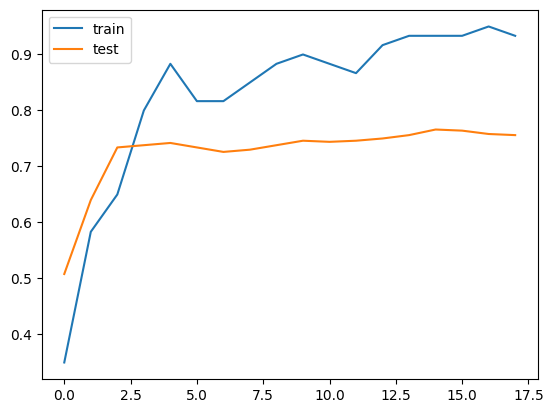

training GCN layers: 4
Validation accuracy: 23.80
Validation accuracy: 55.00
Validation accuracy: 54.40
Validation accuracy: 55.00
Validation accuracy: 59.80
Validation accuracy: 63.60
Validation accuracy: 65.40
Validation accuracy: 65.00
Validation accuracy: 65.00
Validation accuracy: 67.80
Validation accuracy: 70.80
Validation accuracy: 73.00
Validation accuracy: 73.80
Validation accuracy: 72.80
Validation accuracy: 74.60
Validation accuracy: 73.80
Validation accuracy: 76.20
Validation accuracy: 77.60
Validation accuracy: 76.20
Validation accuracy: 76.60
Validation accuracy: 78.00
Validation accuracy: 76.60
Early stopping...
Final test accuracy: 74.60


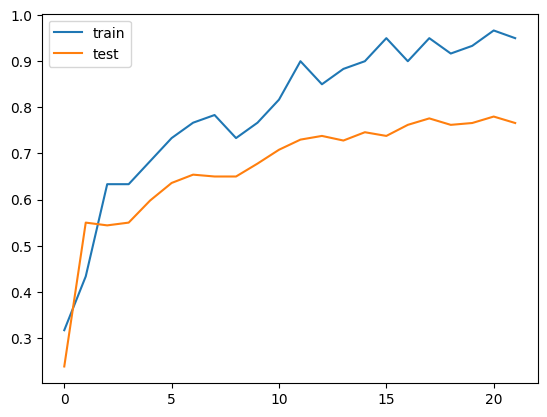

training GCN layers: 5
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 35.40
Validation accuracy: 46.60
Validation accuracy: 50.00
Validation accuracy: 50.00
Validation accuracy: 50.80
Validation accuracy: 51.80
Validation accuracy: 51.40
Validation accuracy: 53.00
Validation accuracy: 55.40
Validation accuracy: 68.80
Validation accuracy: 72.60
Validation accuracy: 75.40
Validation accuracy: 76.00
Validation accuracy: 77.60
Validation accuracy: 77.00
Validation accuracy: 78.80
Validation accuracy: 77.60
Validation accuracy: 77.40
Validation accuracy: 77.40
Validation accuracy: 78.60
Validation accuracy: 78.40
Validation accuracy: 77.00
Early stopping...
Final test accuracy: 75.50


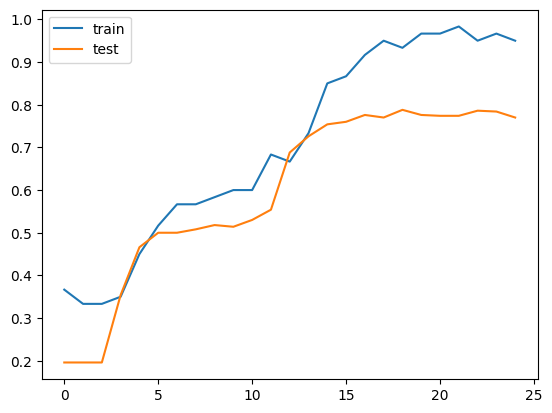

training GCN layers: 6
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 40.80
Validation accuracy: 45.40
Validation accuracy: 46.00
Validation accuracy: 50.00
Validation accuracy: 50.40
Validation accuracy: 50.80
Validation accuracy: 52.20
Validation accuracy: 52.40
Validation accuracy: 52.40
Validation accuracy: 52.60
Validation accuracy: 69.40
Validation accuracy: 72.00
Validation accuracy: 67.80
Validation accuracy: 72.20
Validation accuracy: 72.60
Validation accuracy: 71.40
Validation accuracy: 74.80
Validation accuracy: 73.40
Validation accuracy: 74.20
Validation accuracy: 76.80
Validation accuracy: 76.80
Validation accuracy: 73.60
Validation accuracy: 75.20
Validation accuracy: 78.40
Validation accuracy: 79.20
Validation accuracy: 77.40
Validation accuracy: 75.20
Early stopping...
Final test accuracy: 72.60


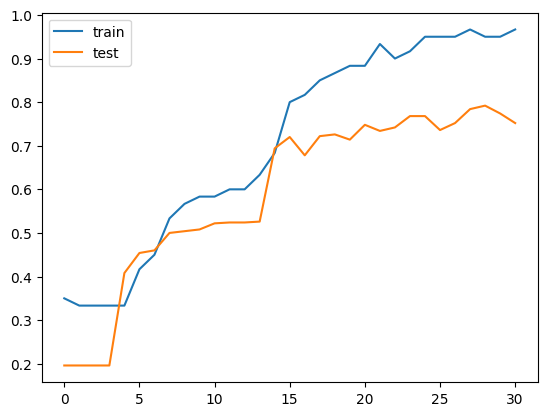

training GCN layers: 7
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 20.20
Validation accuracy: 48.40
Validation accuracy: 50.80
Validation accuracy: 52.20
Validation accuracy: 54.60
Validation accuracy: 53.20
Validation accuracy: 53.60
Validation accuracy: 54.80
Validation accuracy: 54.60
Validation accuracy: 53.60
Validation accuracy: 52.00
Validation accuracy: 59.00
Validation accuracy: 64.80
Validation accuracy: 65.60
Validation accuracy: 62.20
Validation accuracy: 62.20
Validation accuracy: 71.00
Validation accuracy: 65.00
Early stopping...
Final test accuracy: 65.20


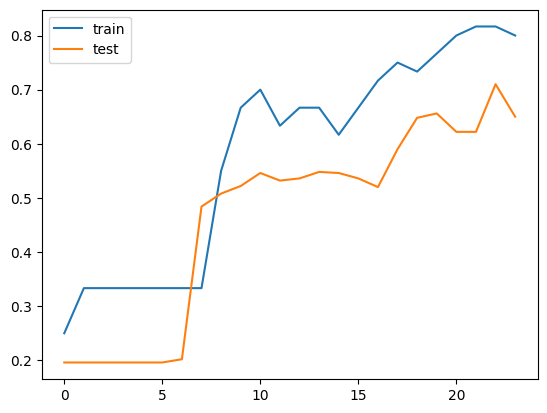

training GCN layers: 8
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 29.60
Validation accuracy: 48.60
Validation accuracy: 50.60
Validation accuracy: 49.60
Validation accuracy: 50.60
Validation accuracy: 51.20
Validation accuracy: 50.40
Validation accuracy: 48.80
Validation accuracy: 51.00
Validation accuracy: 51.60
Validation accuracy: 48.60
Validation accuracy: 49.40
Validation accuracy: 51.20
Validation accuracy: 52.00
Validation accuracy: 51.60
Validation accuracy: 51.00
Early stopping...
Final test accuracy: 50.50


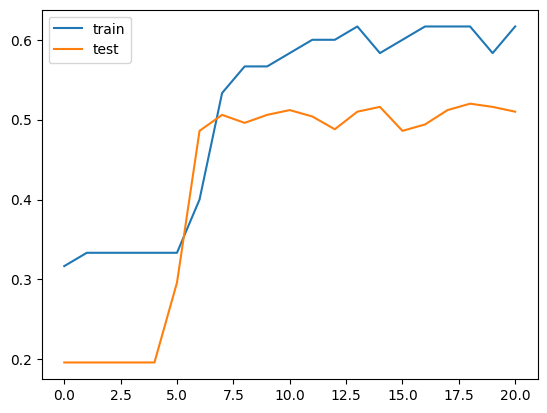

training GCN layers: 9
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 42.80
Validation accuracy: 36.20
Validation accuracy: 47.60
Validation accuracy: 50.00
Validation accuracy: 50.00
Validation accuracy: 49.80
Validation accuracy: 48.60
Validation accuracy: 50.00
Validation accuracy: 50.40
Validation accuracy: 48.40
Validation accuracy: 48.60
Validation accuracy: 51.20
Validation accuracy: 51.60
Validation accuracy: 51.40
Validation accuracy: 55.60
Validation accuracy: 51.60
Early stopping...
Final test accuracy: 50.60


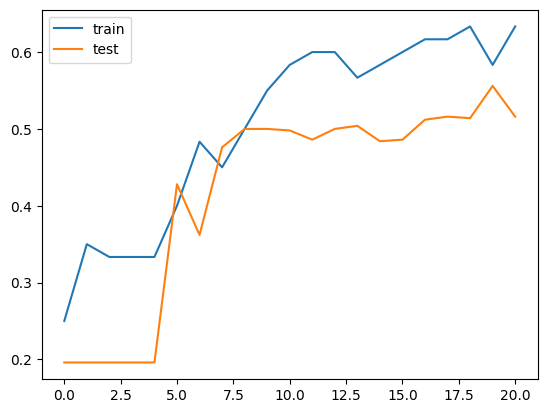

training GCN layers: 10
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 20.20
Validation accuracy: 25.00
Validation accuracy: 56.20
Validation accuracy: 54.40
Validation accuracy: 54.40
Validation accuracy: 51.60
Validation accuracy: 54.40
Validation accuracy: 54.20
Validation accuracy: 50.00
Validation accuracy: 48.60
Validation accuracy: 51.40
Validation accuracy: 50.60
Early stopping...
Final test accuracy: 50.00


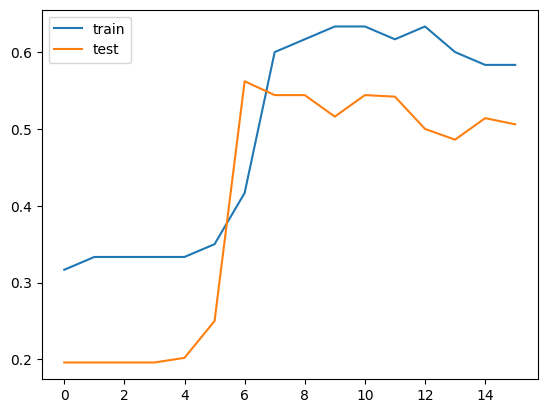

training GAT layers: 0
Validation accuracy: 42.40
Validation accuracy: 46.00
Validation accuracy: 46.60
Validation accuracy: 47.20
Validation accuracy: 49.00
Validation accuracy: 53.00
Validation accuracy: 56.80
Validation accuracy: 61.00
Validation accuracy: 62.20
Validation accuracy: 65.20
Validation accuracy: 65.20
Validation accuracy: 65.20
Validation accuracy: 65.80
Validation accuracy: 67.00
Validation accuracy: 67.20
Validation accuracy: 67.20
Validation accuracy: 67.00
Validation accuracy: 67.20
Validation accuracy: 67.20
Validation accuracy: 67.60
Validation accuracy: 68.00
Validation accuracy: 67.60
Validation accuracy: 67.80
Validation accuracy: 68.40
Validation accuracy: 68.20
Validation accuracy: 68.40
Validation accuracy: 68.80
Validation accuracy: 69.20
Validation accuracy: 69.40
Validation accuracy: 69.60
Validation accuracy: 69.80
Validation accuracy: 69.60
Validation accuracy: 70.00
Validation accuracy: 70.40
Validation accuracy: 70.20
Validation accuracy: 70.20
Valid

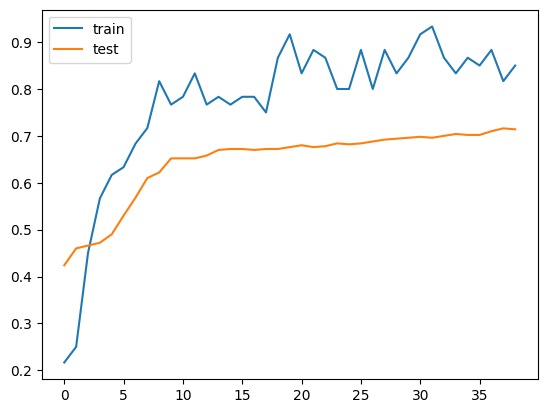

training GAT layers: 1
Validation accuracy: 56.00
Validation accuracy: 59.60
Validation accuracy: 68.40
Validation accuracy: 70.00
Validation accuracy: 72.20
Validation accuracy: 72.40
Validation accuracy: 72.80
Validation accuracy: 71.60
Validation accuracy: 71.60
Validation accuracy: 71.80
Validation accuracy: 71.20
Validation accuracy: 71.80
Validation accuracy: 72.20
Validation accuracy: 72.00
Validation accuracy: 72.40
Validation accuracy: 72.80
Validation accuracy: 74.00
Validation accuracy: 73.80
Validation accuracy: 74.40
Validation accuracy: 73.60
Validation accuracy: 73.40
Early stopping...
Final test accuracy: 70.80


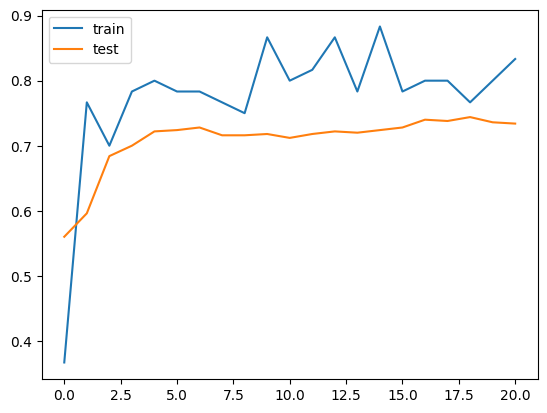

training GAT layers: 2
Validation accuracy: 47.40
Validation accuracy: 52.40
Validation accuracy: 59.40
Validation accuracy: 62.80
Validation accuracy: 65.20
Validation accuracy: 65.20
Validation accuracy: 69.20
Validation accuracy: 69.20
Validation accuracy: 70.00
Validation accuracy: 69.80
Validation accuracy: 69.80
Validation accuracy: 69.60
Validation accuracy: 71.00
Validation accuracy: 71.40
Validation accuracy: 71.60
Validation accuracy: 72.20
Validation accuracy: 72.80
Validation accuracy: 72.40
Validation accuracy: 73.00
Validation accuracy: 72.80
Validation accuracy: 73.60
Validation accuracy: 74.00
Validation accuracy: 73.80
Validation accuracy: 73.60
Early stopping...
Final test accuracy: 70.10


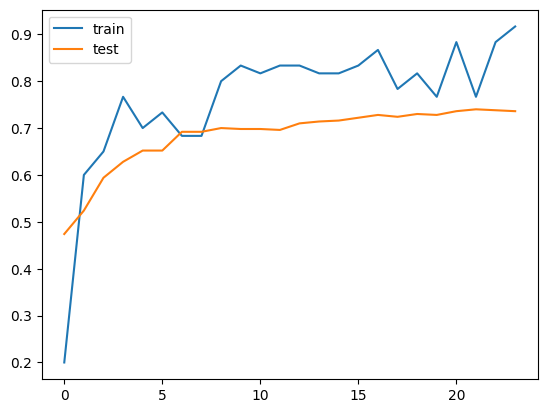

training GAT layers: 3
Validation accuracy: 46.00
Validation accuracy: 61.40
Validation accuracy: 69.20
Validation accuracy: 70.40
Validation accuracy: 69.00
Validation accuracy: 65.80
Validation accuracy: 68.20
Validation accuracy: 70.80
Validation accuracy: 70.80
Validation accuracy: 70.80
Validation accuracy: 70.80
Validation accuracy: 71.40
Validation accuracy: 73.40
Validation accuracy: 74.20
Validation accuracy: 75.00
Validation accuracy: 75.80
Validation accuracy: 74.40
Validation accuracy: 75.20
Validation accuracy: 76.60
Validation accuracy: 75.40
Validation accuracy: 75.60
Validation accuracy: 76.40
Validation accuracy: 73.80
Validation accuracy: 74.80
Validation accuracy: 78.40
Validation accuracy: 77.20
Early stopping...
Final test accuracy: 75.60


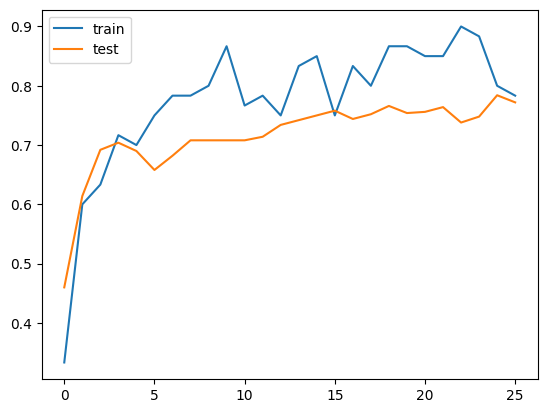

training GAT layers: 4
Validation accuracy: 39.00
Validation accuracy: 52.80
Validation accuracy: 59.80
Validation accuracy: 61.80
Validation accuracy: 62.80
Validation accuracy: 67.60
Validation accuracy: 69.80
Validation accuracy: 70.80
Validation accuracy: 70.20
Validation accuracy: 72.60
Validation accuracy: 72.80
Validation accuracy: 74.20
Validation accuracy: 75.00
Validation accuracy: 71.20
Validation accuracy: 73.80
Validation accuracy: 75.40
Validation accuracy: 75.20
Validation accuracy: 72.40
Validation accuracy: 72.80
Validation accuracy: 74.60
Validation accuracy: 74.40
Validation accuracy: 76.40
Validation accuracy: 75.40
Early stopping...
Final test accuracy: 72.40


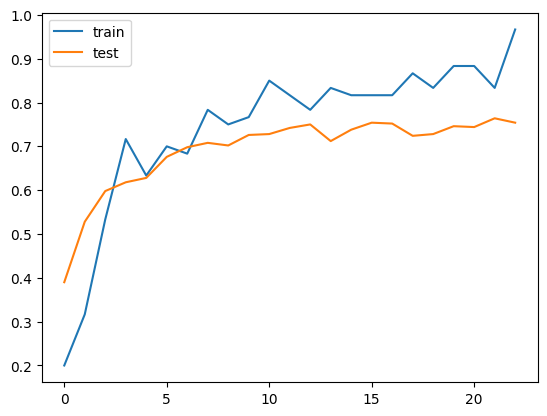

training GAT layers: 5
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 53.40
Validation accuracy: 45.60
Validation accuracy: 61.20
Validation accuracy: 67.20
Validation accuracy: 67.60
Validation accuracy: 70.60
Validation accuracy: 69.60
Validation accuracy: 71.60
Validation accuracy: 74.20
Validation accuracy: 76.80
Validation accuracy: 74.20
Validation accuracy: 74.60
Validation accuracy: 73.40
Validation accuracy: 69.60
Validation accuracy: 77.00
Validation accuracy: 74.40
Early stopping...
Final test accuracy: 72.50


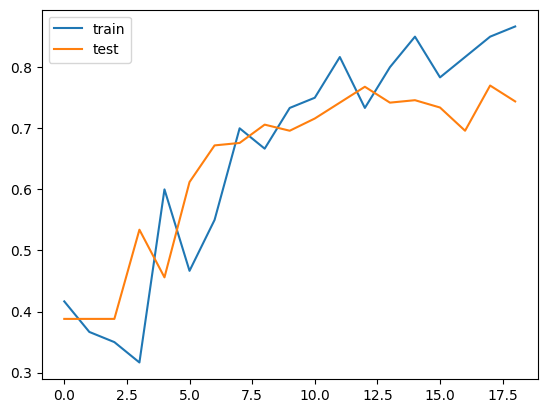

training GAT layers: 6
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 44.40
Validation accuracy: 38.80
Validation accuracy: 67.40
Validation accuracy: 53.80
Validation accuracy: 59.60
Validation accuracy: 70.20
Validation accuracy: 69.20
Validation accuracy: 70.80
Validation accuracy: 71.80
Validation accuracy: 73.00
Validation accuracy: 70.40
Validation accuracy: 69.00
Validation accuracy: 68.00
Early stopping...
Final test accuracy: 67.70


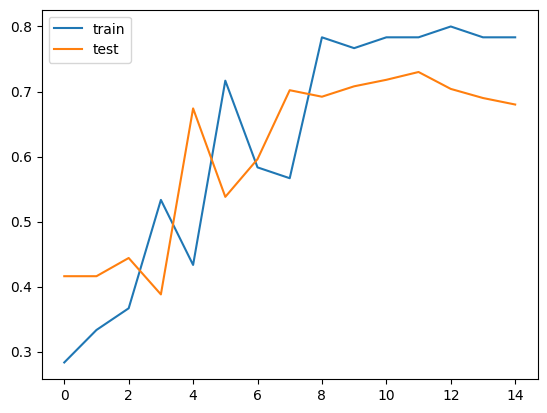

training GAT layers: 7
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 46.60
Validation accuracy: 51.00
Validation accuracy: 57.00
Validation accuracy: 52.20
Validation accuracy: 58.60
Validation accuracy: 61.20
Validation accuracy: 56.00
Validation accuracy: 65.20
Validation accuracy: 54.00
Validation accuracy: 63.80
Validation accuracy: 71.40
Validation accuracy: 72.20
Validation accuracy: 72.00
Validation accuracy: 62.60
Validation accuracy: 69.60
Validation accuracy: 72.00
Validation accuracy: 67.40
Early stopping...
Final test accuracy: 65.60


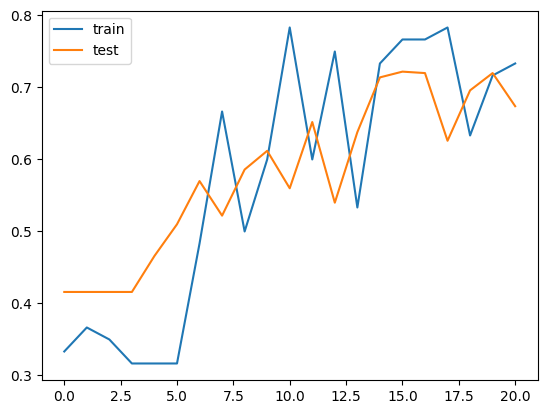

training GAT layers: 8
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 39.80
Validation accuracy: 59.40
Validation accuracy: 59.80
Validation accuracy: 59.80
Validation accuracy: 60.80
Validation accuracy: 61.20
Validation accuracy: 60.80
Validation accuracy: 60.60
Validation accuracy: 61.60
Validation accuracy: 59.20
Validation accuracy: 62.60
Validation accuracy: 66.60
Validation accuracy: 57.80
Validation accuracy: 61.80
Validation accuracy: 68.80
Validation accuracy: 66.60
Early stopping...
Final test accuracy: 65.70


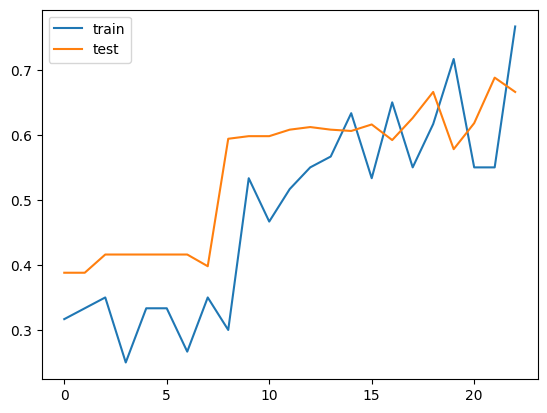

training GAT layers: 9
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 32.80
Validation accuracy: 35.80
Validation accuracy: 60.40
Validation accuracy: 59.80
Validation accuracy: 60.20
Validation accuracy: 63.40
Validation accuracy: 61.20
Validation accuracy: 58.60
Validation accuracy: 59.20
Validation accuracy: 44.40
Validation accuracy: 56.80
Validation accuracy: 59.00
Validation accuracy: 57.00
Early stopping...
Final test accuracy: 57.60


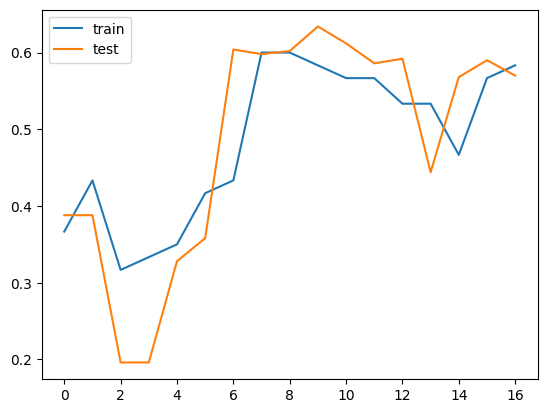

training GAT layers: 10
Validation accuracy: 41.60
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 40.80
Validation accuracy: 45.00
Validation accuracy: 48.40
Validation accuracy: 48.00
Validation accuracy: 54.40
Validation accuracy: 46.40
Validation accuracy: 45.40
Validation accuracy: 51.40
Validation accuracy: 52.40
Validation accuracy: 53.80
Validation accuracy: 54.80
Validation accuracy: 52.80
Validation accuracy: 59.40
Validation accuracy: 58.20
Early stopping...
Final test accuracy: 58.10


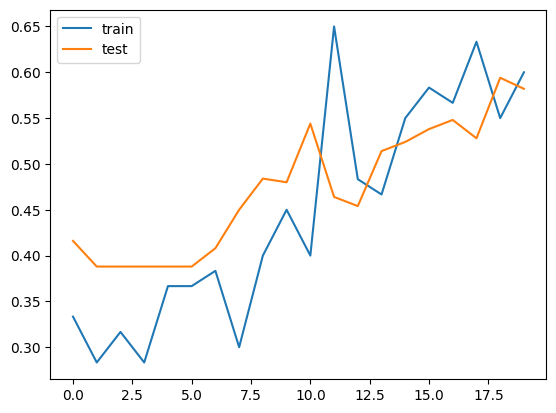

training GATv2 layers: 0
Validation accuracy: 20.00
Validation accuracy: 22.40
Validation accuracy: 26.80
Validation accuracy: 31.20
Validation accuracy: 38.40
Validation accuracy: 46.00
Validation accuracy: 52.20
Validation accuracy: 58.00
Validation accuracy: 60.20
Validation accuracy: 64.20
Validation accuracy: 63.60
Validation accuracy: 64.40
Validation accuracy: 64.40
Validation accuracy: 64.80
Validation accuracy: 64.60
Validation accuracy: 65.00
Validation accuracy: 65.20
Validation accuracy: 66.00
Validation accuracy: 67.60
Validation accuracy: 67.60
Validation accuracy: 68.20
Validation accuracy: 68.40
Validation accuracy: 69.00
Validation accuracy: 68.20
Validation accuracy: 68.00
Validation accuracy: 68.40
Validation accuracy: 68.20
Validation accuracy: 68.60
Validation accuracy: 68.80
Validation accuracy: 68.40
Early stopping...
Final test accuracy: 66.80


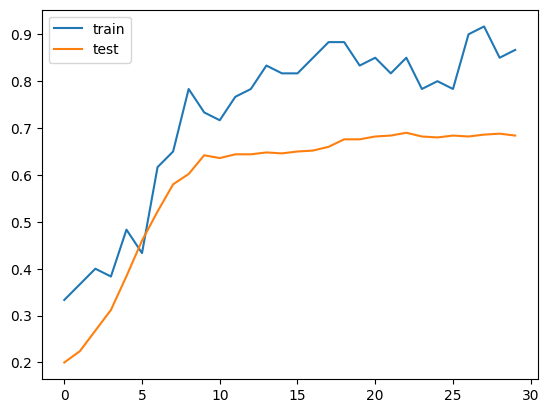

training GATv2 layers: 1
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 52.00
Validation accuracy: 58.00
Validation accuracy: 65.00
Validation accuracy: 67.60
Validation accuracy: 66.60
Validation accuracy: 67.00
Validation accuracy: 66.60
Validation accuracy: 67.60
Validation accuracy: 69.00
Validation accuracy: 70.40
Validation accuracy: 70.80
Validation accuracy: 70.80
Validation accuracy: 71.00
Validation accuracy: 71.00
Validation accuracy: 71.20
Validation accuracy: 71.40
Validation accuracy: 71.20
Validation accuracy: 71.40
Validation accuracy: 71.80
Validation accuracy: 71.80
Validation accuracy: 72.40
Validation accuracy: 72.00
Validation accuracy: 72.60
Validation accuracy: 72.60
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 73.40
Validation accuracy: 73.40
Validation accuracy: 73.60
Validation accuracy: 73.80
Validation accuracy: 74.20
Validation accuracy: 74.40
Validation accuracy: 74.40
Validation accuracy: 74.40
Val

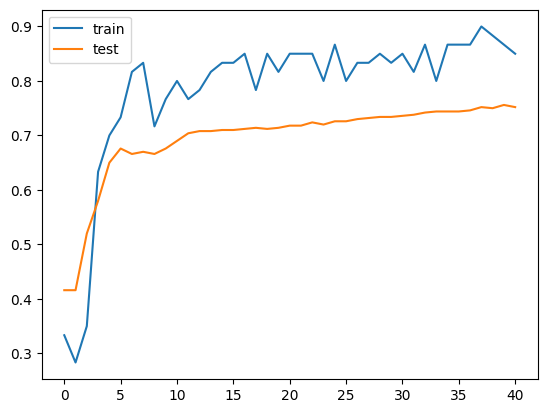

training GATv2 layers: 2
Validation accuracy: 19.60
Validation accuracy: 40.60
Validation accuracy: 41.20
Validation accuracy: 52.20
Validation accuracy: 72.00
Validation accuracy: 67.80
Validation accuracy: 61.40
Validation accuracy: 54.20
Validation accuracy: 57.40
Validation accuracy: 66.40
Validation accuracy: 70.40
Validation accuracy: 70.80
Validation accuracy: 71.20
Validation accuracy: 72.00
Validation accuracy: 72.20
Validation accuracy: 71.40
Validation accuracy: 72.20
Validation accuracy: 71.60
Validation accuracy: 71.40
Early stopping...
Final test accuracy: 68.10


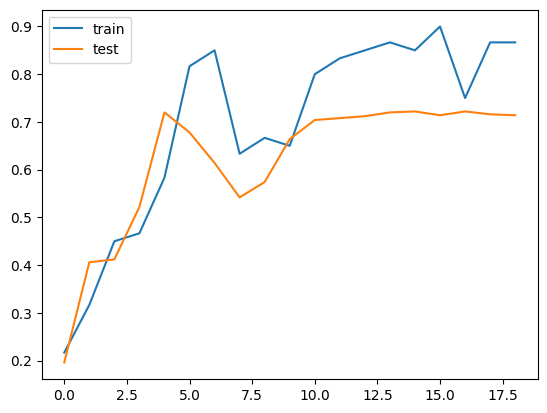

training GATv2 layers: 3
Validation accuracy: 19.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 70.60
Validation accuracy: 70.00
Validation accuracy: 64.40
Validation accuracy: 66.40
Validation accuracy: 67.00
Validation accuracy: 72.40
Validation accuracy: 71.60
Validation accuracy: 70.80
Validation accuracy: 71.00
Validation accuracy: 72.00
Validation accuracy: 73.80
Validation accuracy: 74.80
Validation accuracy: 73.80
Validation accuracy: 75.00
Validation accuracy: 75.40
Validation accuracy: 76.00
Validation accuracy: 76.00
Validation accuracy: 77.80
Validation accuracy: 76.60
Early stopping...
Final test accuracy: 75.50


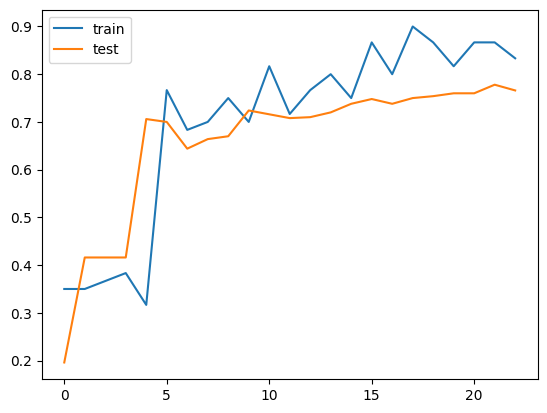

training GATv2 layers: 4
Validation accuracy: 38.80
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 44.80
Validation accuracy: 50.80
Validation accuracy: 50.40
Validation accuracy: 62.60
Validation accuracy: 65.80
Validation accuracy: 71.40
Validation accuracy: 68.60
Validation accuracy: 70.20
Validation accuracy: 73.00
Validation accuracy: 72.40
Validation accuracy: 72.60
Validation accuracy: 70.20
Validation accuracy: 71.40
Validation accuracy: 71.60
Validation accuracy: 72.80
Validation accuracy: 75.80
Validation accuracy: 71.60
Early stopping...
Final test accuracy: 69.90


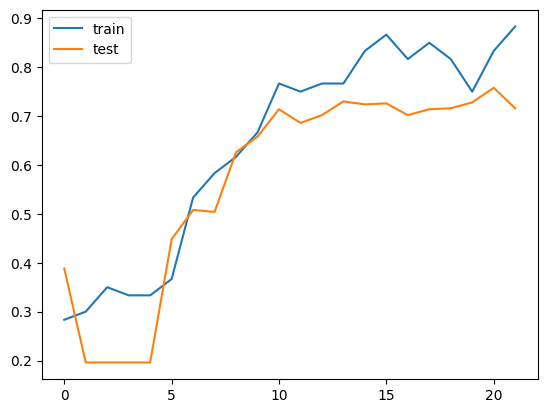

training GATv2 layers: 5
Validation accuracy: 19.60
Validation accuracy: 40.20
Validation accuracy: 53.40
Validation accuracy: 38.80
Validation accuracy: 56.40
Validation accuracy: 58.60
Validation accuracy: 63.20
Validation accuracy: 70.80
Validation accuracy: 70.00
Validation accuracy: 68.20
Validation accuracy: 71.40
Validation accuracy: 65.40
Validation accuracy: 70.40
Validation accuracy: 67.40
Validation accuracy: 72.00
Validation accuracy: 73.40
Validation accuracy: 75.00
Validation accuracy: 75.80
Validation accuracy: 73.60
Early stopping...
Final test accuracy: 72.30


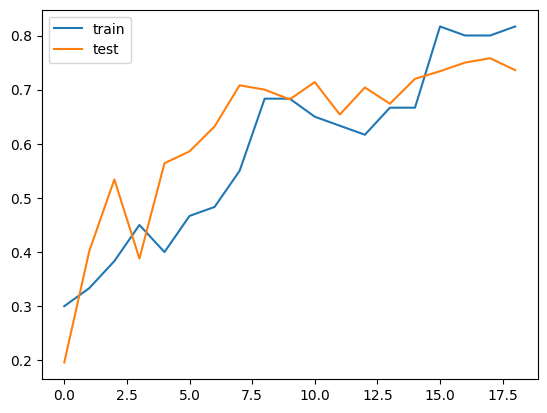

training GATv2 layers: 6
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 53.00
Validation accuracy: 60.80
Validation accuracy: 68.20
Validation accuracy: 70.00
Validation accuracy: 70.20
Validation accuracy: 69.00
Validation accuracy: 70.60
Validation accuracy: 72.40
Validation accuracy: 72.60
Validation accuracy: 72.20
Validation accuracy: 72.00
Validation accuracy: 71.20
Validation accuracy: 72.20
Validation accuracy: 66.20
Validation accuracy: 74.20
Validation accuracy: 73.80
Early stopping...
Final test accuracy: 69.20


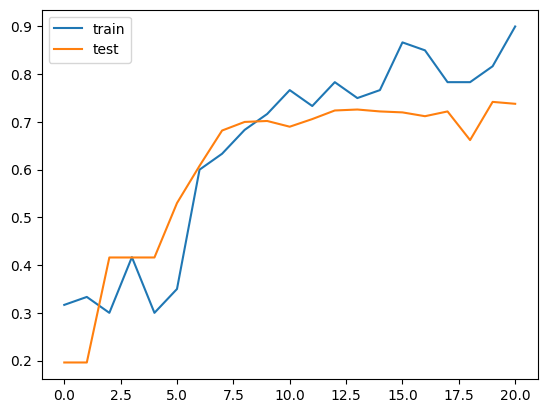

training GATv2 layers: 7
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 50.20
Validation accuracy: 49.60
Validation accuracy: 69.20
Validation accuracy: 68.20
Validation accuracy: 64.20
Validation accuracy: 62.40
Early stopping...
Final test accuracy: 61.90


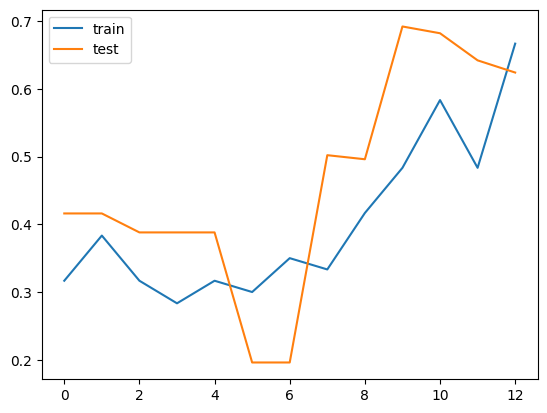

training GATv2 layers: 8
Validation accuracy: 38.80
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 46.00
Validation accuracy: 52.00
Validation accuracy: 51.80
Validation accuracy: 51.80
Validation accuracy: 51.00
Validation accuracy: 51.40
Validation accuracy: 50.80
Validation accuracy: 51.40
Validation accuracy: 51.80
Validation accuracy: 53.40
Validation accuracy: 53.40
Validation accuracy: 50.60
Validation accuracy: 53.20
Validation accuracy: 51.40
Early stopping...
Final test accuracy: 49.00


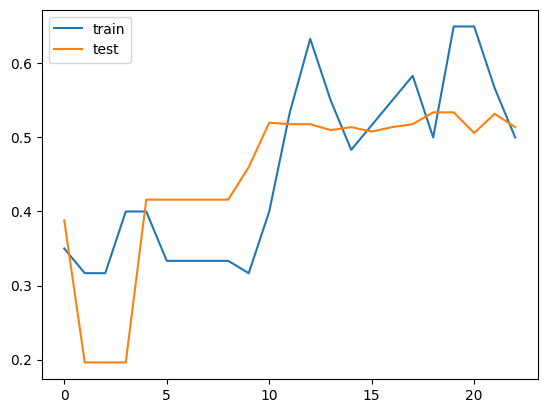

training GATv2 layers: 9
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 45.60
Validation accuracy: 53.00
Validation accuracy: 57.60
Validation accuracy: 43.00
Validation accuracy: 51.40
Validation accuracy: 63.80
Validation accuracy: 58.80
Validation accuracy: 49.60
Validation accuracy: 54.00
Validation accuracy: 49.20
Validation accuracy: 69.20
Validation accuracy: 69.80
Validation accuracy: 65.00
Validation accuracy: 68.60
Validation accuracy: 66.60
Early stopping...
Final test accuracy: 63.80


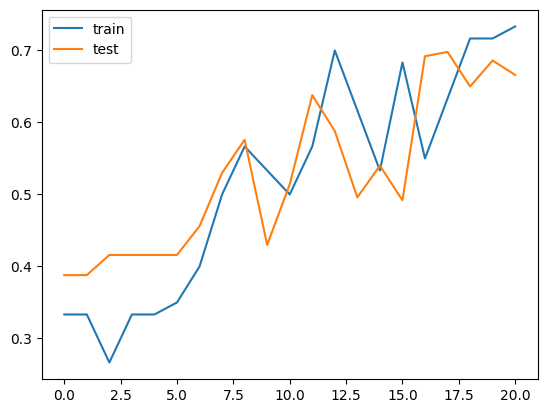

training GATv2 layers: 10
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 52.00
Validation accuracy: 38.60
Validation accuracy: 41.00
Validation accuracy: 45.60
Validation accuracy: 66.40
Validation accuracy: 44.20
Validation accuracy: 49.80
Validation accuracy: 44.60
Validation accuracy: 41.80
Validation accuracy: 51.80
Validation accuracy: 63.20
Validation accuracy: 42.40
Early stopping...
Final test accuracy: 44.00


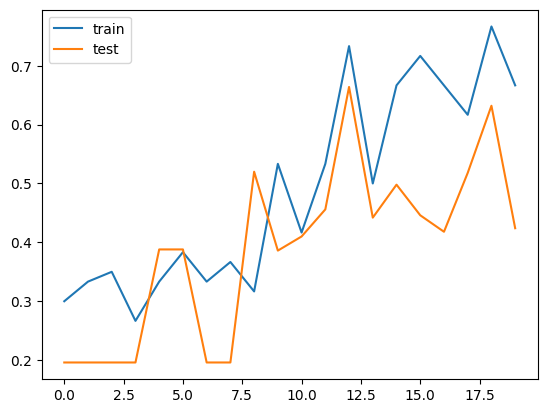

training InterleaveGATGCN layers: 0
Validation accuracy: 38.00
Validation accuracy: 46.40
Validation accuracy: 51.00
Validation accuracy: 56.80
Validation accuracy: 62.20
Validation accuracy: 67.60
Validation accuracy: 70.00
Validation accuracy: 72.20
Validation accuracy: 73.60
Validation accuracy: 73.40
Validation accuracy: 74.00
Validation accuracy: 74.40
Validation accuracy: 74.20
Validation accuracy: 74.40
Validation accuracy: 74.20
Validation accuracy: 74.00
Validation accuracy: 74.00
Validation accuracy: 73.80
Validation accuracy: 73.20
Early stopping...
Final test accuracy: 71.80


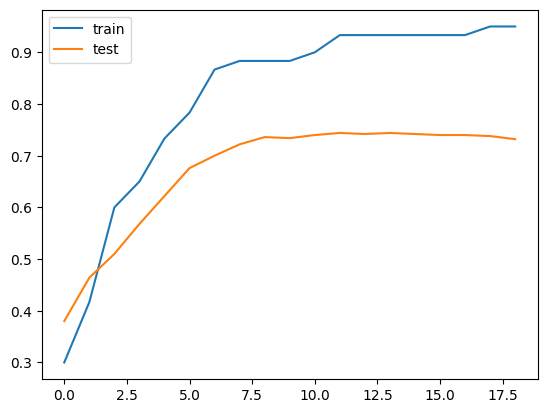

training InterleaveGATGCN layers: 1
Validation accuracy: 63.60
Validation accuracy: 70.80
Validation accuracy: 72.20
Validation accuracy: 72.80
Validation accuracy: 73.20
Validation accuracy: 73.80
Validation accuracy: 74.00
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.60
Validation accuracy: 74.40
Validation accuracy: 74.00
Validation accuracy: 73.80
Validation accuracy: 73.60
Validation accuracy: 73.20
Validation accuracy: 73.80
Validation accuracy: 74.00
Validation accuracy: 74.20
Validation accuracy: 74.40
Validation accuracy: 74.40
Validation accuracy: 74.20
Early stopping...
Final test accuracy: 73.80


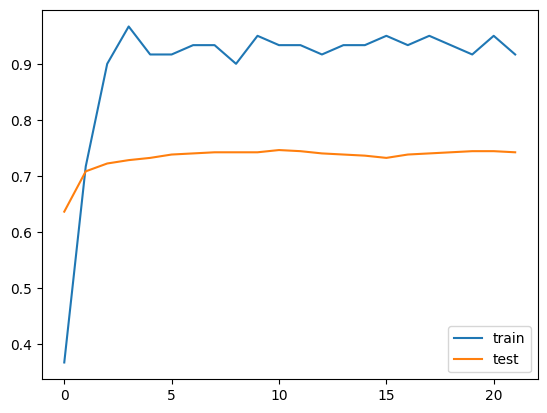

training InterleaveGATGCN layers: 2
Validation accuracy: 59.60
Validation accuracy: 72.20
Validation accuracy: 71.80
Validation accuracy: 73.20
Validation accuracy: 73.80
Validation accuracy: 73.00
Validation accuracy: 73.40
Validation accuracy: 75.00
Validation accuracy: 75.20
Validation accuracy: 74.80
Validation accuracy: 74.40
Validation accuracy: 74.40
Validation accuracy: 75.20
Validation accuracy: 74.60
Validation accuracy: 74.60
Validation accuracy: 75.00
Validation accuracy: 75.60
Validation accuracy: 76.00
Validation accuracy: 76.00
Validation accuracy: 76.60
Validation accuracy: 78.00
Validation accuracy: 78.00
Validation accuracy: 77.40
Early stopping...
Final test accuracy: 76.40


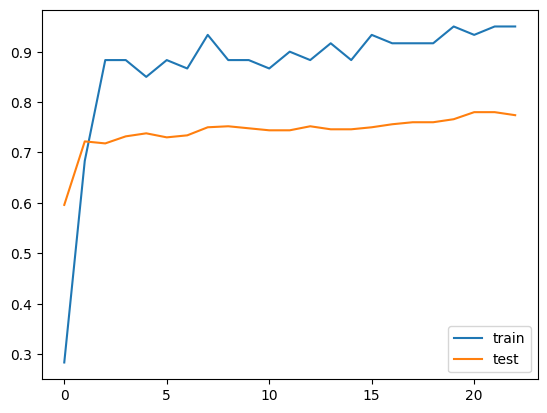

training InterleaveGATGCN layers: 3
Validation accuracy: 51.00
Validation accuracy: 61.80
Validation accuracy: 63.80
Validation accuracy: 63.60
Validation accuracy: 66.40
Validation accuracy: 69.40
Validation accuracy: 69.80
Validation accuracy: 70.40
Validation accuracy: 71.40
Validation accuracy: 71.80
Validation accuracy: 72.40
Validation accuracy: 74.00
Validation accuracy: 75.20
Validation accuracy: 77.40
Validation accuracy: 78.60
Validation accuracy: 79.00
Validation accuracy: 78.80
Validation accuracy: 78.60
Validation accuracy: 80.80
Validation accuracy: 78.80
Validation accuracy: 79.60
Validation accuracy: 77.80
Validation accuracy: 79.40
Validation accuracy: 80.20
Validation accuracy: 78.20
Early stopping...
Final test accuracy: 77.10


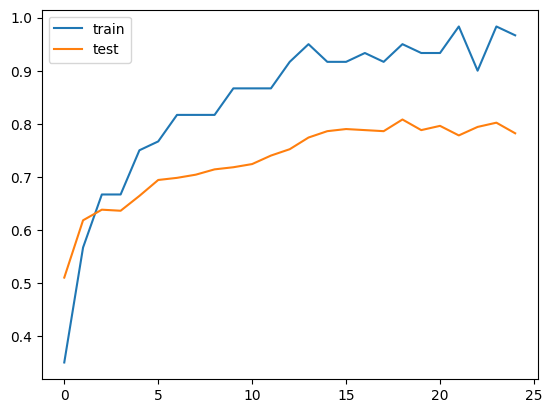

training InterleaveGATGCN layers: 4
Validation accuracy: 51.60
Validation accuracy: 52.40
Validation accuracy: 53.20
Validation accuracy: 53.40
Validation accuracy: 53.80
Validation accuracy: 54.00
Validation accuracy: 53.80
Validation accuracy: 55.80
Validation accuracy: 69.80
Validation accuracy: 70.40
Validation accuracy: 72.60
Validation accuracy: 72.40
Validation accuracy: 72.60
Validation accuracy: 72.20
Validation accuracy: 74.60
Validation accuracy: 73.60
Validation accuracy: 74.40
Validation accuracy: 75.80
Validation accuracy: 75.40
Validation accuracy: 76.40
Validation accuracy: 77.40
Validation accuracy: 78.40
Validation accuracy: 78.00
Early stopping...
Final test accuracy: 75.90


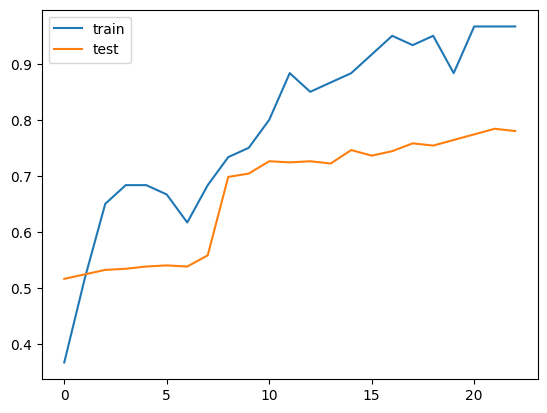

training InterleaveGATGCN layers: 5
Validation accuracy: 38.80
Validation accuracy: 39.80
Validation accuracy: 69.40
Validation accuracy: 69.80
Validation accuracy: 69.80
Validation accuracy: 70.20
Validation accuracy: 70.80
Validation accuracy: 69.80
Validation accuracy: 70.20
Validation accuracy: 71.00
Validation accuracy: 72.00
Validation accuracy: 74.40
Validation accuracy: 73.00
Validation accuracy: 70.80
Validation accuracy: 72.60
Validation accuracy: 69.20
Validation accuracy: 67.40
Validation accuracy: 73.80
Validation accuracy: 68.00
Early stopping...
Final test accuracy: 65.20


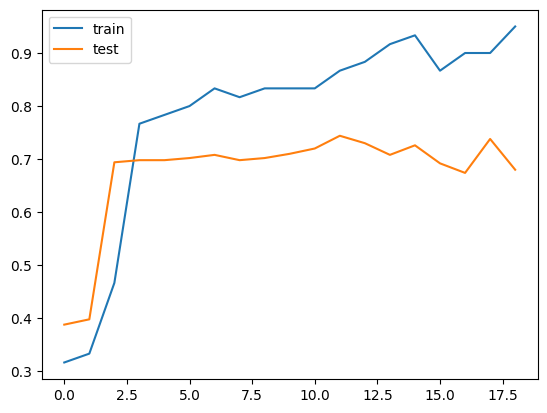

training InterleaveGATGCN layers: 6
Validation accuracy: 42.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 42.80
Validation accuracy: 53.20
Validation accuracy: 53.80
Validation accuracy: 53.20
Validation accuracy: 55.80
Validation accuracy: 69.60
Validation accuracy: 72.60
Validation accuracy: 73.00
Validation accuracy: 73.60
Validation accuracy: 77.60
Validation accuracy: 72.60
Validation accuracy: 75.80
Validation accuracy: 80.20
Validation accuracy: 75.00
Validation accuracy: 79.60
Validation accuracy: 79.00
Validation accuracy: 73.60
Early stopping...
Final test accuracy: 71.40


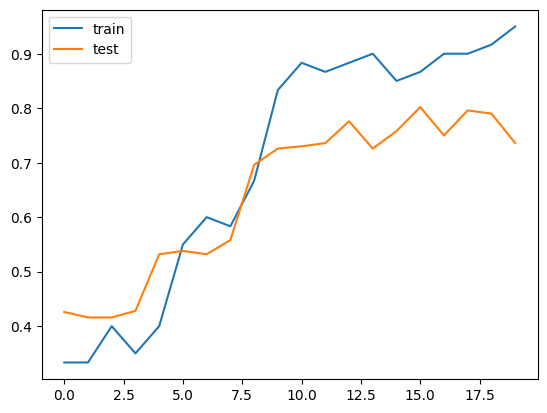

training InterleaveGATGCN layers: 7
Validation accuracy: 41.60
Validation accuracy: 20.40
Validation accuracy: 37.00
Validation accuracy: 45.20
Validation accuracy: 50.00
Validation accuracy: 56.40
Validation accuracy: 55.60
Validation accuracy: 56.40
Validation accuracy: 57.80
Validation accuracy: 58.40
Validation accuracy: 58.20
Validation accuracy: 71.40
Validation accuracy: 63.40
Validation accuracy: 73.00
Validation accuracy: 66.60
Validation accuracy: 65.00
Early stopping...
Final test accuracy: 64.60


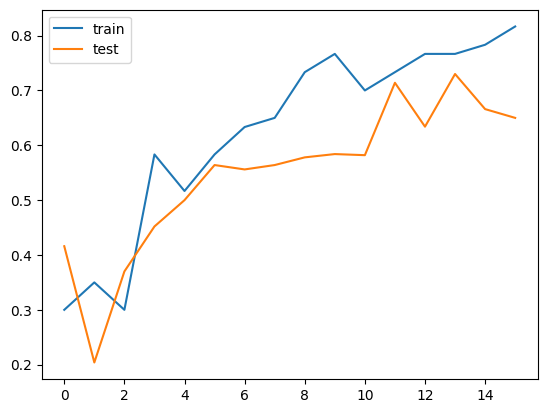

training InterleaveGATGCN layers: 8
Validation accuracy: 41.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 41.40
Validation accuracy: 36.80
Validation accuracy: 45.40
Validation accuracy: 54.80
Validation accuracy: 56.00
Validation accuracy: 50.60
Validation accuracy: 52.40
Validation accuracy: 68.60
Validation accuracy: 71.40
Validation accuracy: 72.20
Validation accuracy: 71.80
Validation accuracy: 72.20
Validation accuracy: 71.60
Validation accuracy: 74.00
Validation accuracy: 72.60
Early stopping...
Final test accuracy: 70.90


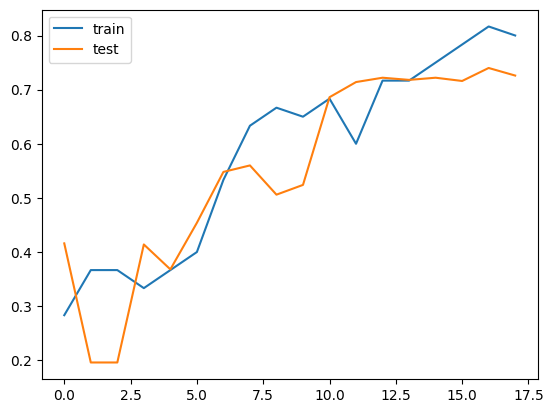

training InterleaveGATGCN layers: 9
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 27.40
Validation accuracy: 36.20
Validation accuracy: 46.20
Validation accuracy: 57.60
Validation accuracy: 69.20
Validation accuracy: 70.40
Validation accuracy: 69.40
Validation accuracy: 64.60
Validation accuracy: 72.80
Validation accuracy: 73.00
Validation accuracy: 61.20
Validation accuracy: 68.00
Validation accuracy: 52.00
Validation accuracy: 55.80
Validation accuracy: 71.00
Validation accuracy: 69.80
Validation accuracy: 72.60
Validation accuracy: 72.40
Early stopping...
Final test accuracy: 69.20


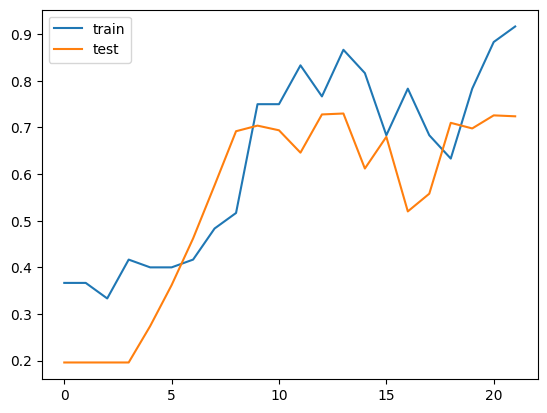

training InterleaveGATGCN layers: 10
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 38.40
Validation accuracy: 40.60
Validation accuracy: 41.00
Validation accuracy: 43.60
Validation accuracy: 51.80
Validation accuracy: 39.60
Validation accuracy: 38.40
Validation accuracy: 50.40
Validation accuracy: 71.40
Validation accuracy: 71.00
Validation accuracy: 63.40
Validation accuracy: 72.00
Validation accuracy: 65.20
Validation accuracy: 54.20
Early stopping...
Final test accuracy: 51.20


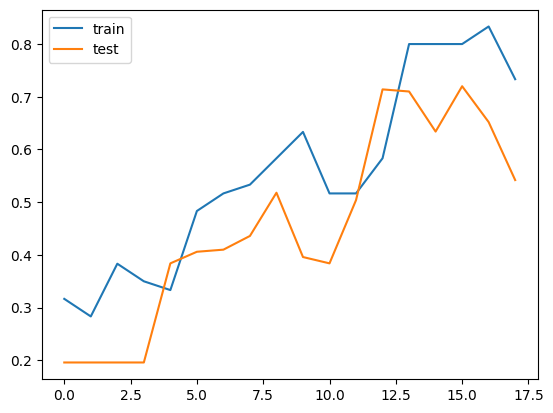

training InterleaveGATv2GCN layers: 0
Validation accuracy: 34.80
Validation accuracy: 42.40
Validation accuracy: 46.60
Validation accuracy: 51.40
Validation accuracy: 58.00
Validation accuracy: 61.80
Validation accuracy: 64.80
Validation accuracy: 66.60
Validation accuracy: 69.40
Validation accuracy: 69.80
Validation accuracy: 71.20
Validation accuracy: 70.40
Validation accuracy: 70.80
Validation accuracy: 71.40
Validation accuracy: 71.20
Validation accuracy: 72.40
Validation accuracy: 71.60
Validation accuracy: 72.20
Validation accuracy: 72.80
Validation accuracy: 72.80
Validation accuracy: 72.40
Validation accuracy: 72.60
Validation accuracy: 72.40
Validation accuracy: 72.00
Early stopping...
Final test accuracy: 72.10


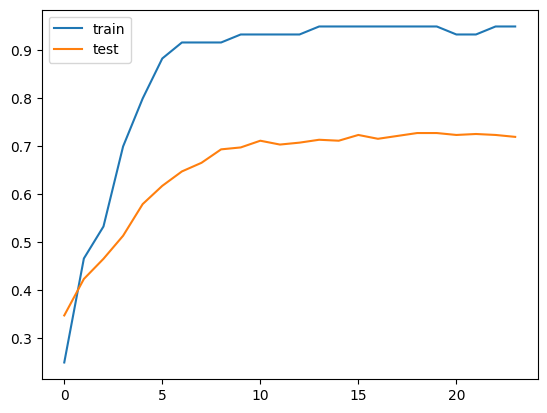

training InterleaveGATv2GCN layers: 1
Validation accuracy: 44.80
Validation accuracy: 69.60
Validation accuracy: 72.60
Validation accuracy: 73.20
Validation accuracy: 73.40
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 73.20
Validation accuracy: 73.00
Validation accuracy: 73.20
Validation accuracy: 74.20
Validation accuracy: 73.80
Validation accuracy: 73.80
Validation accuracy: 73.60
Validation accuracy: 74.00
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.20
Validation accuracy: 74.00
Validation accuracy: 74.00
Validation accuracy: 74.40
Validation accuracy: 75.00
Validation accuracy: 75.20
Validation accuracy: 75.60
Validation accuracy: 75.80
Validation accuracy: 76.00
Validation accuracy: 76.20
Validation accuracy: 76.00
Early stopping...
Final test accuracy: 73.60


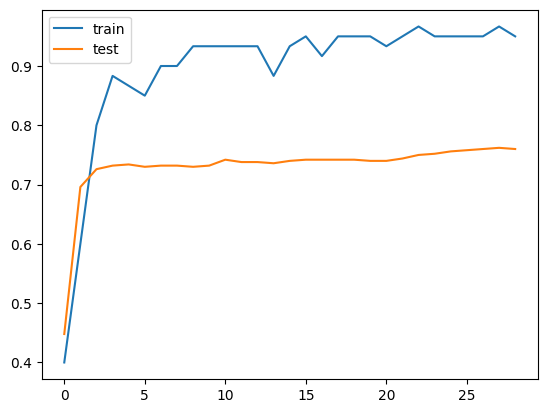

training InterleaveGATv2GCN layers: 2
Validation accuracy: 51.00
Validation accuracy: 54.80
Validation accuracy: 69.20
Validation accuracy: 68.20
Validation accuracy: 69.60
Validation accuracy: 70.20
Validation accuracy: 70.40
Validation accuracy: 70.80
Validation accuracy: 70.20
Validation accuracy: 70.20
Validation accuracy: 70.20
Validation accuracy: 69.80
Validation accuracy: 70.20
Validation accuracy: 70.80
Validation accuracy: 71.20
Validation accuracy: 71.40
Validation accuracy: 72.00
Validation accuracy: 72.60
Validation accuracy: 73.20
Validation accuracy: 74.00
Validation accuracy: 74.60
Validation accuracy: 74.20
Validation accuracy: 74.00
Validation accuracy: 75.00
Validation accuracy: 74.80
Early stopping...
Final test accuracy: 73.00


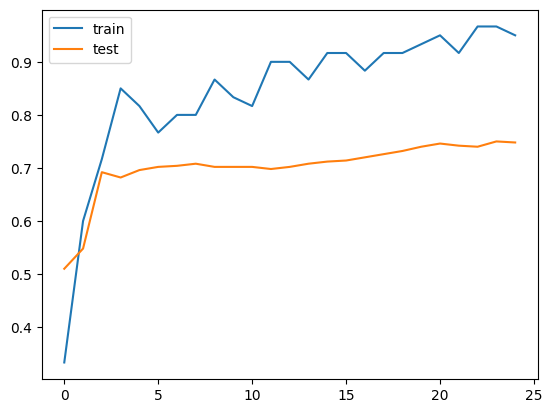

training InterleaveGATv2GCN layers: 3
Validation accuracy: 19.60
Validation accuracy: 48.80
Validation accuracy: 64.40
Validation accuracy: 70.20
Validation accuracy: 65.40
Validation accuracy: 63.80
Validation accuracy: 65.80
Validation accuracy: 67.00
Validation accuracy: 68.60
Validation accuracy: 70.00
Validation accuracy: 70.20
Validation accuracy: 70.60
Validation accuracy: 72.00
Validation accuracy: 73.20
Validation accuracy: 72.60
Validation accuracy: 73.20
Validation accuracy: 73.80
Validation accuracy: 75.00
Validation accuracy: 75.20
Validation accuracy: 76.20
Validation accuracy: 76.60
Validation accuracy: 76.00
Validation accuracy: 75.40
Validation accuracy: 78.00
Validation accuracy: 77.00
Early stopping...
Final test accuracy: 76.20


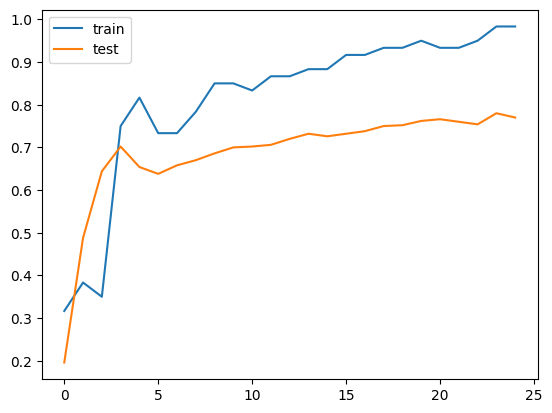

training InterleaveGATv2GCN layers: 4
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 58.80
Validation accuracy: 54.60
Validation accuracy: 55.20
Validation accuracy: 61.40
Validation accuracy: 61.80
Validation accuracy: 58.80
Validation accuracy: 58.40
Validation accuracy: 64.00
Validation accuracy: 68.00
Validation accuracy: 65.80
Validation accuracy: 71.20
Validation accuracy: 72.00
Validation accuracy: 71.60
Validation accuracy: 73.00
Validation accuracy: 74.40
Validation accuracy: 74.00
Early stopping...
Final test accuracy: 69.90


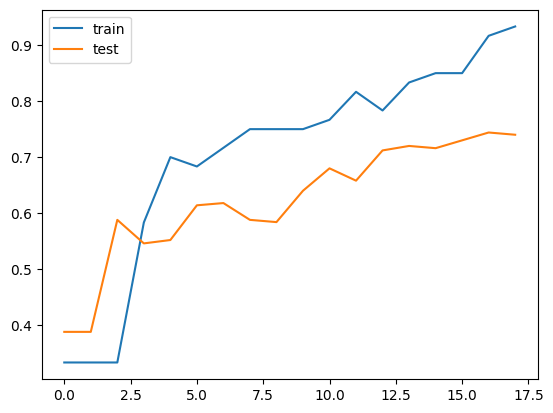

training InterleaveGATv2GCN layers: 5
Validation accuracy: 37.00
Validation accuracy: 19.60
Validation accuracy: 55.00
Validation accuracy: 53.40
Validation accuracy: 55.00
Validation accuracy: 60.00
Validation accuracy: 61.40
Validation accuracy: 57.20
Validation accuracy: 56.20
Validation accuracy: 60.40
Validation accuracy: 62.40
Validation accuracy: 65.40
Validation accuracy: 68.60
Validation accuracy: 69.00
Validation accuracy: 68.00
Validation accuracy: 68.60
Validation accuracy: 68.20
Early stopping...
Final test accuracy: 67.60


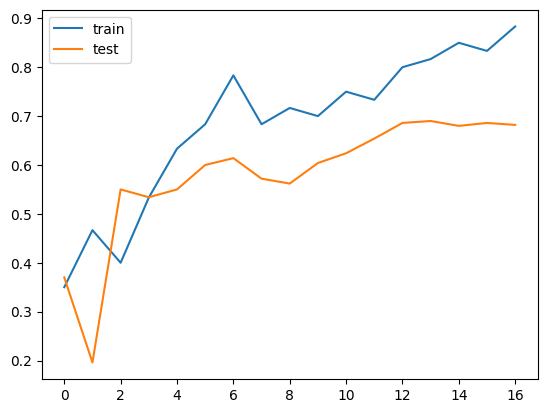

training InterleaveGATv2GCN layers: 6
Validation accuracy: 19.60
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 56.00
Validation accuracy: 66.00
Validation accuracy: 69.60
Validation accuracy: 67.40
Validation accuracy: 69.00
Validation accuracy: 70.80
Validation accuracy: 70.80
Validation accuracy: 71.20
Validation accuracy: 70.60
Validation accuracy: 74.00
Validation accuracy: 73.20
Validation accuracy: 73.40
Validation accuracy: 73.40
Validation accuracy: 75.40
Validation accuracy: 73.80
Validation accuracy: 68.60
Validation accuracy: 74.40
Validation accuracy: 78.00
Validation accuracy: 77.00
Early stopping...
Final test accuracy: 74.80


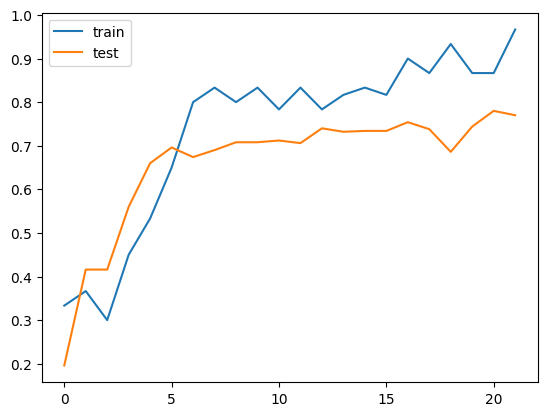

training InterleaveGATv2GCN layers: 7
Validation accuracy: 38.80
Validation accuracy: 56.40
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 59.00
Validation accuracy: 62.00
Validation accuracy: 69.00
Validation accuracy: 71.80
Validation accuracy: 71.80
Validation accuracy: 71.00
Validation accuracy: 73.00
Validation accuracy: 75.00
Validation accuracy: 75.80
Validation accuracy: 75.60
Validation accuracy: 74.00
Validation accuracy: 60.00
Validation accuracy: 77.20
Validation accuracy: 72.20
Early stopping...
Final test accuracy: 70.40


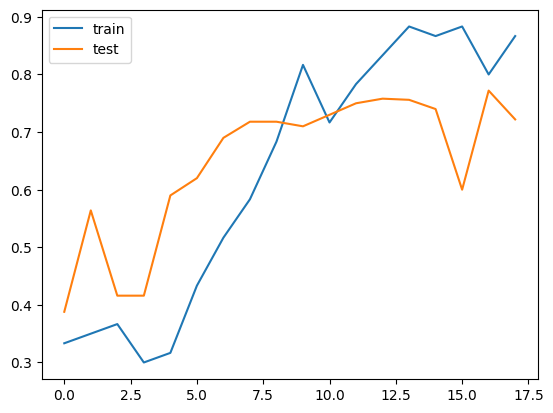

training InterleaveGATv2GCN layers: 8
Validation accuracy: 19.60
Validation accuracy: 41.60
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 45.40
Validation accuracy: 58.20
Validation accuracy: 59.00
Validation accuracy: 70.60
Validation accuracy: 69.80
Validation accuracy: 59.60
Validation accuracy: 58.60
Validation accuracy: 60.00
Validation accuracy: 68.80
Validation accuracy: 66.00
Validation accuracy: 56.00
Early stopping...
Final test accuracy: 53.80


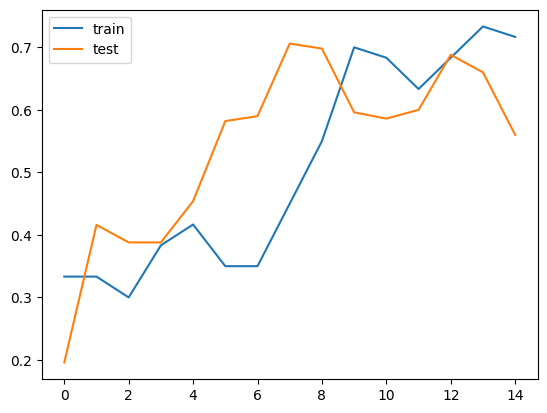

training InterleaveGATv2GCN layers: 9
Validation accuracy: 19.60
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 41.60
Validation accuracy: 41.60
Validation accuracy: 42.20
Validation accuracy: 50.00
Validation accuracy: 64.40
Validation accuracy: 54.40
Validation accuracy: 52.40
Validation accuracy: 52.80
Validation accuracy: 52.00
Validation accuracy: 52.80
Validation accuracy: 51.80
Validation accuracy: 56.00
Validation accuracy: 57.40
Validation accuracy: 62.00
Validation accuracy: 60.00
Validation accuracy: 58.20
Early stopping...
Final test accuracy: 58.20


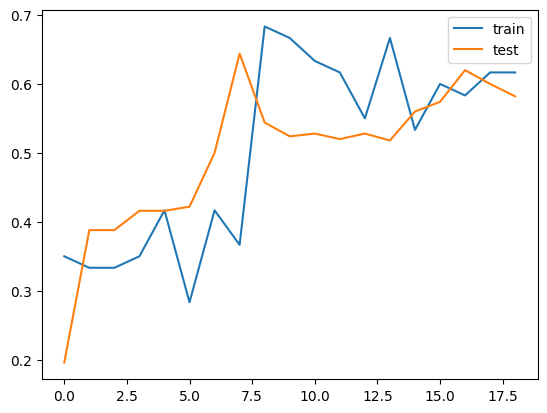

training InterleaveGATv2GCN layers: 10
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 19.60
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 38.80
Validation accuracy: 48.40
Validation accuracy: 48.60
Validation accuracy: 54.20
Validation accuracy: 49.00
Validation accuracy: 51.20
Validation accuracy: 53.20
Validation accuracy: 51.60
Validation accuracy: 53.20
Validation accuracy: 48.20
Validation accuracy: 44.00
Validation accuracy: 45.60
Validation accuracy: 50.20
Validation accuracy: 54.20
Validation accuracy: 53.20
Validation accuracy: 57.60
Validation accuracy: 55.20
Early stopping...
Final test accuracy: 56.40


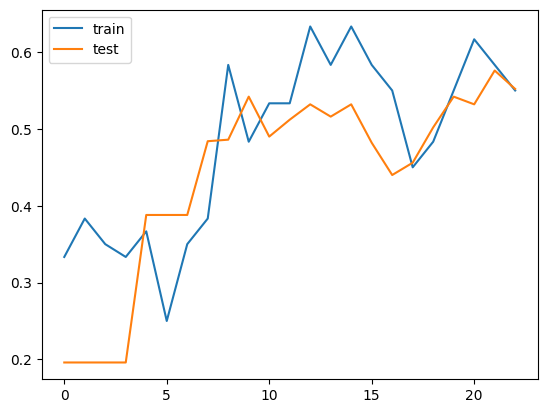

In [306]:
perf_matrix = dict()
max_level = 10

def train_all_levels(model_name, params):
    test_scores = []
    for l_cnt in range(max_level + 1):
        print(f"training {model_name} layers: {l_cnt}")
        m, test_acc = model_n_layer(params, l_cnt)
        test_scores.append(test_acc)
    perf_matrix[model_name] = test_scores

train_all_levels("GCN", training_params)
train_all_levels("GAT", gat_params)
train_all_levels("GATv2", gatv2_params)
train_all_levels("InterleaveGATGCN", interleave_params)
train_all_levels("InterleaveGATv2GCN", interleavev2_params)

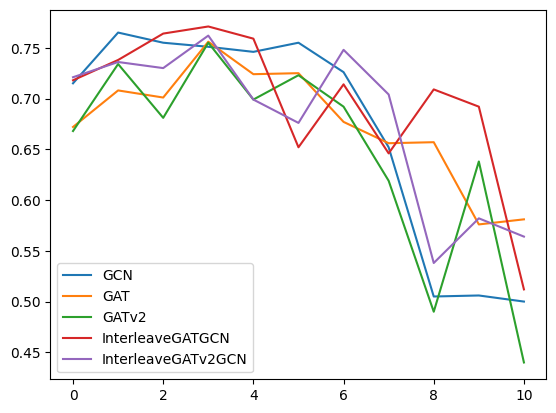

In [308]:
def plot_all_levels(scores_dict):
    for model_name in scores_dict.keys():
        plt.plot(scores_dict[model_name], label=model_name)
    plt.legend()
    plt.show()

plot_all_levels(perf_matrix)

Visualizing embedded features with TSNE

In [321]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [322]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
  mask = dataset.data.val_mask
  emb = model.generate_node_embeddings(dataset.data.x, dataset.data.edge_index).cpu().detach().numpy()
  
  emb = TSNE(n_components=2).fit_transform(emb)
  
  labels = dataset.data.y.cpu().detach().numpy()
  df = pd.DataFrame(emb, columns = ['dim1', 'dim2'])
  df['labels'] = labels

  return df

#### c. Generate reduced embeddings for each model and save them in a dictionary object

In [272]:
gat_0

SimpleGAT(
  (layers): ModuleList(
    (0): GATConv(1433, 7, heads=1)
  )
)

In [90]:
gatv2_1

SimpleGAT(
  (layers): ModuleList(
    (0): GATConv(1433, 64, heads=1)
    (1): GATConv(64, 7, heads=1)
  )
)

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(gcn_0),
    "1_layer": dimension_reduction(gcn_1),
    "3_layer": dimension_reduction(gcn_3),
    "10_layer": dimension_reduction(gcn_10),
}

In [ ]:
gat_features = {
    "0_layer": dimension_reduction(gat_0),
    "1_layer": dimension_reduction(gat_1),
    "3_layer": dimension_reduction(gat_3),
    "10_layer": dimension_reduction(gat_10),
}

In [ ]:
gatv2_features = {
    "0_layer": dimension_reduction(gatv2_0),
    "1_layer": dimension_reduction(gatv2_1),
    "3_layer": dimension_reduction(gatv2_3),
    "10_layer": dimension_reduction(gatv2_10),
}

In [ ]:
interleave_features = {
    "0_layer": dimension_reduction(interleave_0),
    "1_layer": dimension_reduction(interleave_1),
    "3_layer": dimension_reduction(interleave_3),
    "10_layer": dimension_reduction(interleave_10),
}

In [ ]:
interleavev2_features = {
    "0_layer": dimension_reduction(interleavev2_0),
    "1_layer": dimension_reduction(interleavev2_1),
    "3_layer": dimension_reduction(interleavev2_3),
    "10_layer": dimension_reduction(interleavev2_10),
}

In [323]:
def visualise(feature_dict: typing.Dict) -> None:
    for key, val in feature_dict.items():
      sns.scatterplot(x ='dim1', y = 'dim2', data=val, hue='labels', label = key)
      plt.legend()
      plt.title(key)
      plt.show()

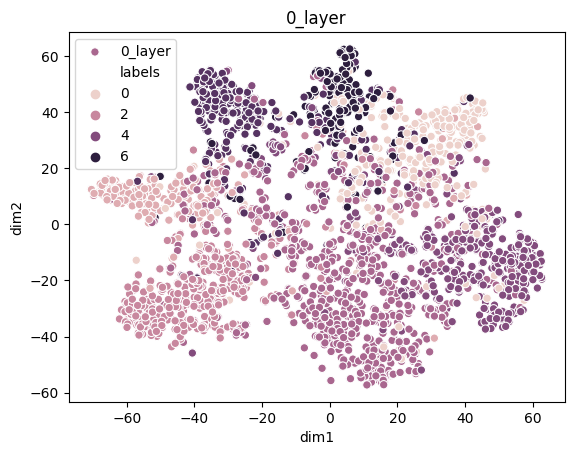

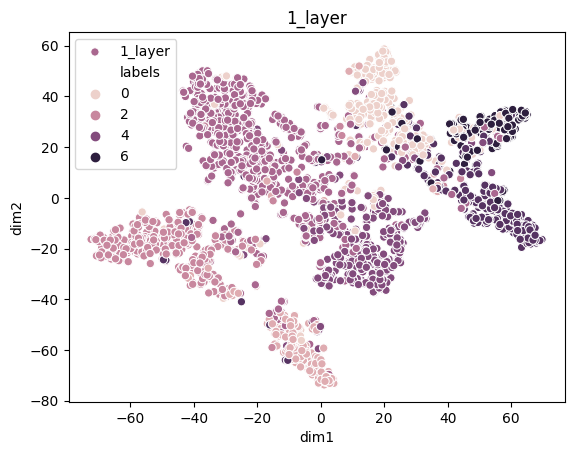

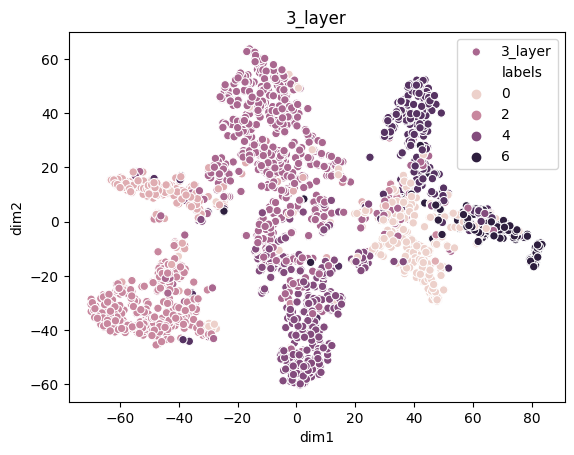

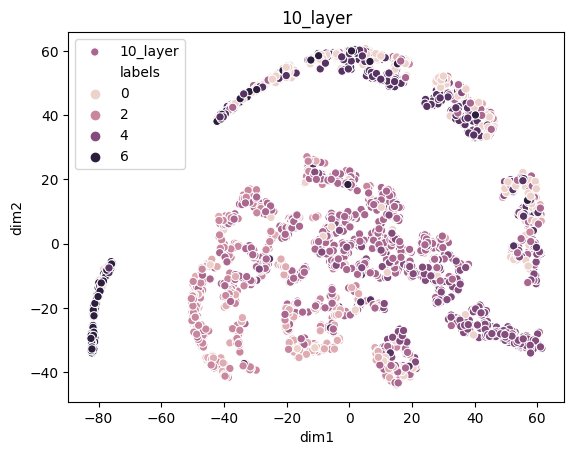

In [332]:
visualise(feature_dict)

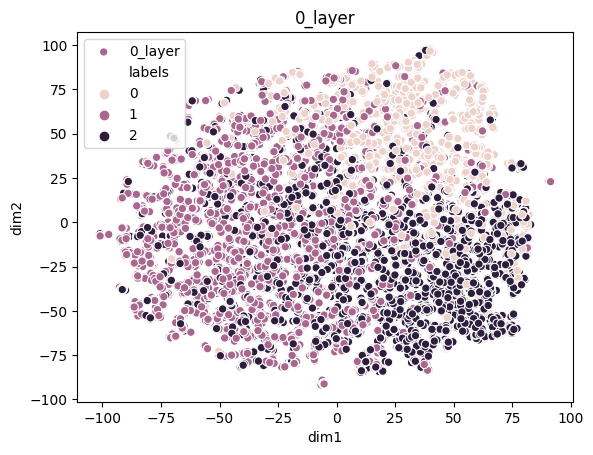

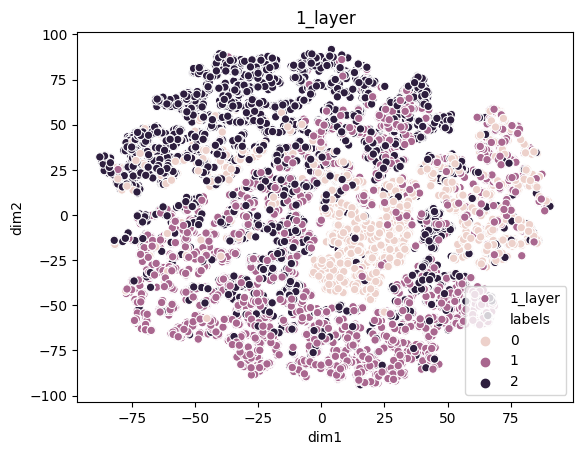

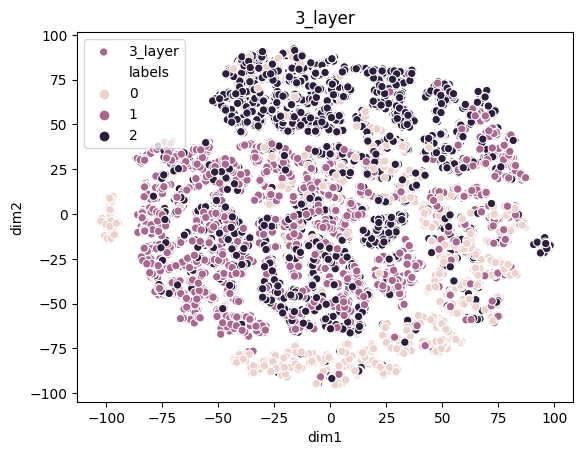

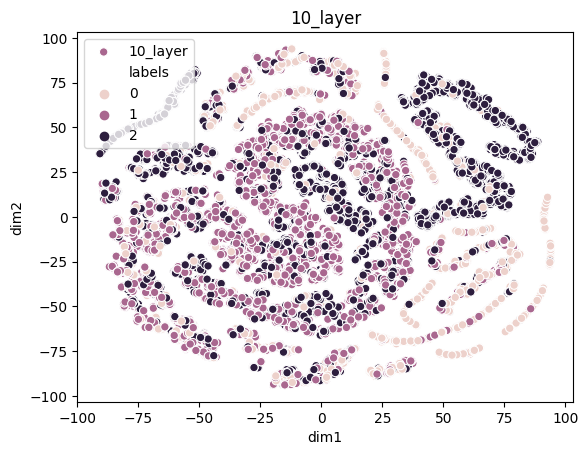

In [325]:
visualise(gat_features)

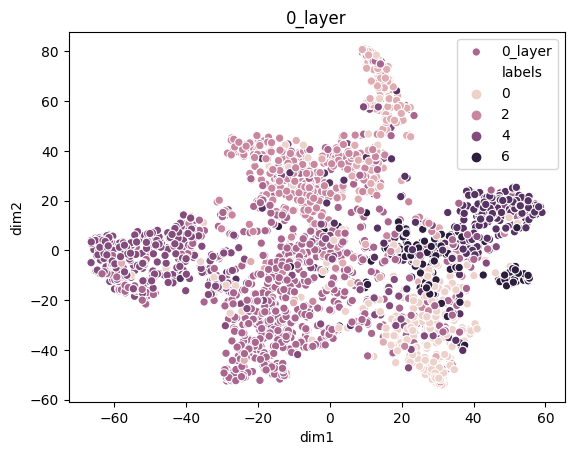

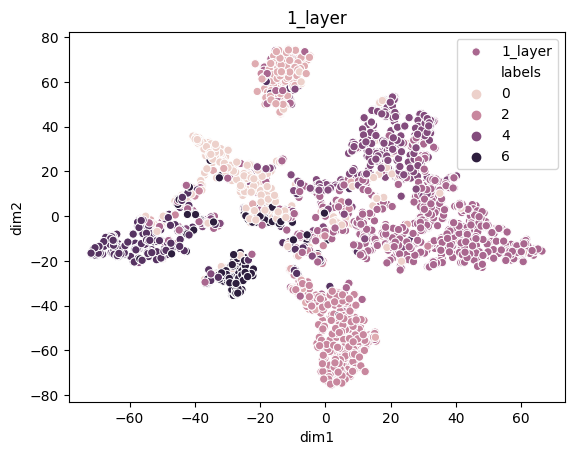

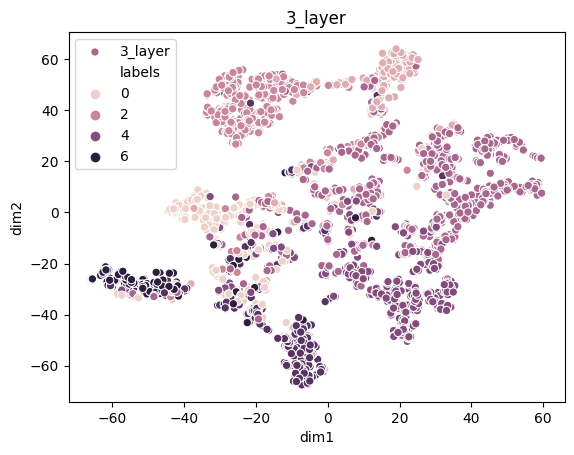

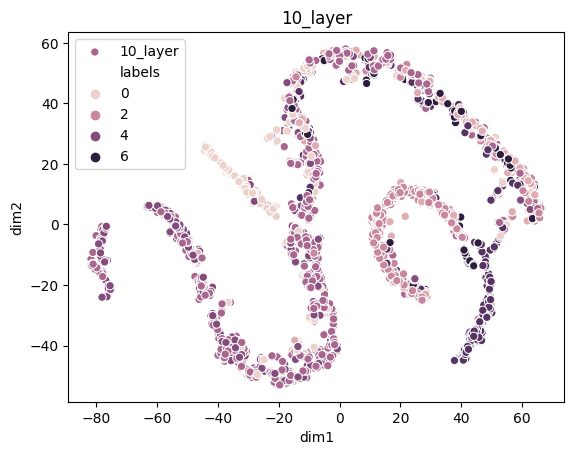

In [326]:
visualise(gatv2_features)

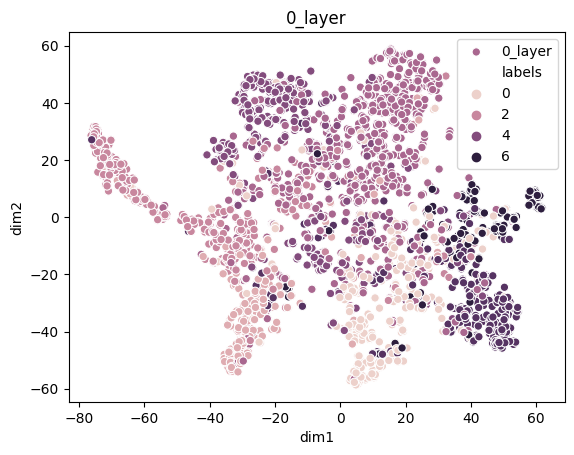

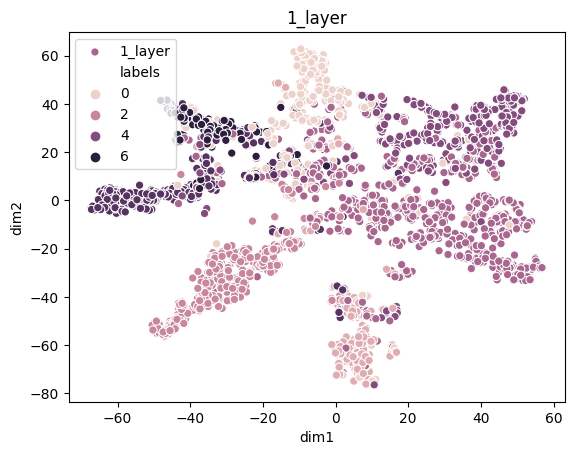

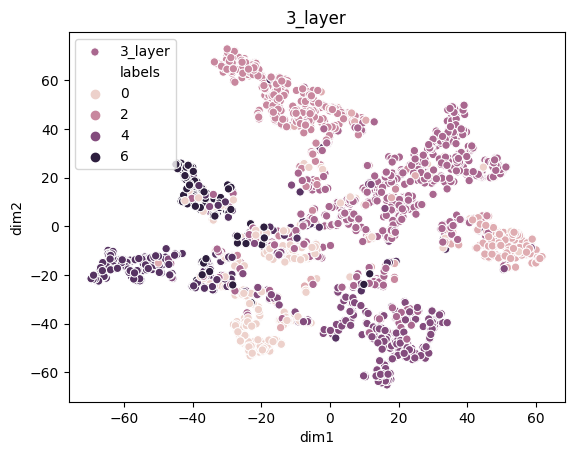

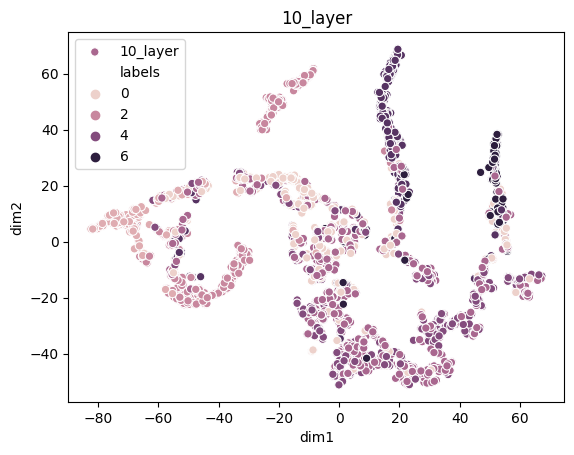

In [327]:
visualise(interleave_features)

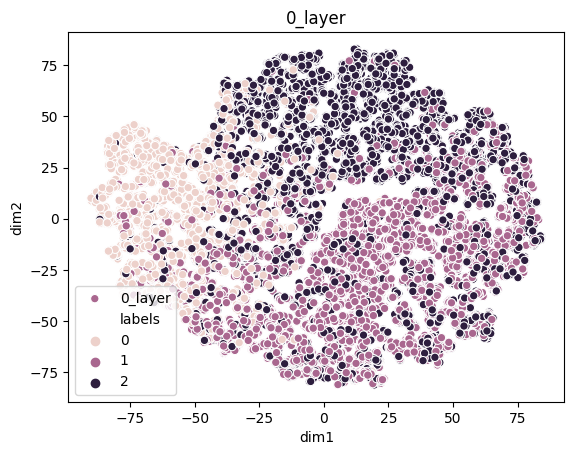

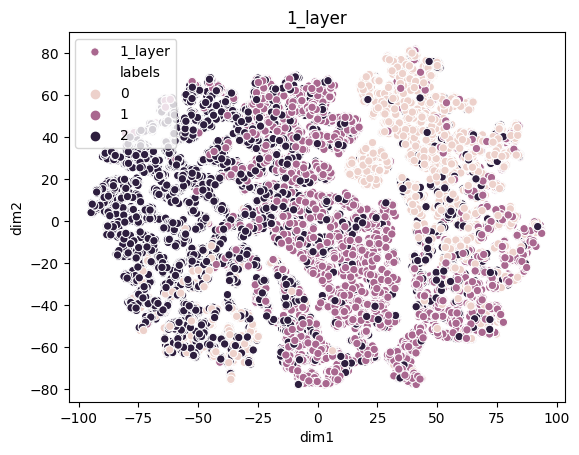

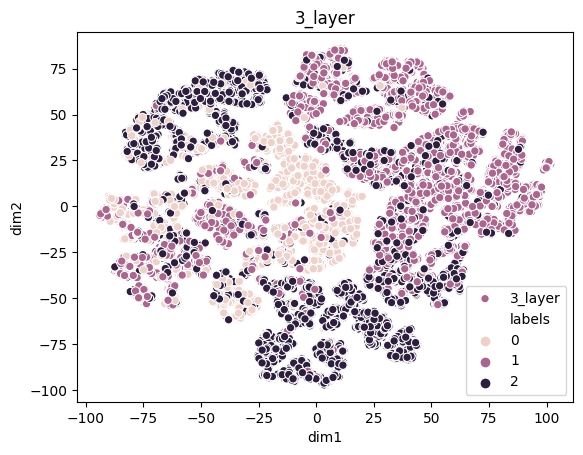

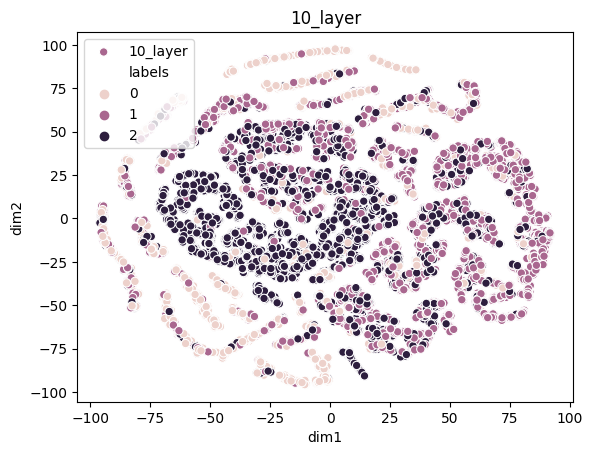

In [331]:
visualise(interleavev2_features)